# Trevor Kunz GenAI Final

### Install Groq and connect to Google Drive
#### Using CPU for this first part since the API call to groq can generate the Q&A Set without the need for using the limited colab A100 compute

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# install requirements from github
!pip install -r https://raw.githubusercontent.com/tskunz/Pre-train-post-train-and-RAG/main/requirements.txt
# not sure why these didn't load with the requirements
!pip install evaluate bert_score
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a681a51444b1190387a81813fc0128757c2029836776b5b540d7e9f8a5dc5972
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


# Generate Synthetic Q&A Pairs
### Using Groq to generate Q&A pairs to use for training the models on the Paul Graham essays.

In [ ]:
import os
import glob
import time
import shutil
import pandas as pd
import subprocess
from groq import Groq, RateLimitError
from google.colab import userdata


# Set up Groq, fast API to connect to LLM's, preserves A100
API_KEY = GROQ_API_KEY

# Due to limited time on each and to provide a more robust synthetic data, we trained on Llama 3 70B, Llama 3 8B (due to limited resources), and Qwen 3 32B
#MODEL_ID = "llama-3.3-70b-versatile"
#MODEL_ID = "qwen/qwen3-32b"
MODEL_ID = "llama-3.1-8b-instant" # this one was essentially the closer that did the last 800 chunks after I'd used all my free tokens on 70B and Qwen
OUTPUT_FILE = "paul_graham_qa_dataset.csv"
BATCH_SIZE = 50


# Rate limits for each of the models. Needed to set up according to the needs, to prevent the code from crashing/burning all the tokens out too fast.
# Rate Limit Settings for Llama 3 70B- Setting the limit based off the usage rates on Groq to try to prevent us from erroring out.
#TPM_LIMIT = 12000
#SAFETY_MARGIN = 0.90
#EFFECTIVE_TPM = TPM_LIMIT * SAFETY_MARGIN

# limits for Qwen
#TPM_LIMIT = 100000
#SAFETY_MARGIN = 0.90
#EFFECTIVE_TPM = TPM_LIMIT * SAFETY_MARGIN

# Rate Limit Settings for Llama 3 8B
TPM_LIMIT = 50000
SAFETY_MARGIN = 0.90
EFFECTIVE_TPM = TPM_LIMIT * SAFETY_MARGIN

# Initialize Groq
client = Groq(api_key=API_KEY)
tokens_used_this_minute = 0
minute_start_time = time.time()

# function to try and estimate the number of tokens to try to minimize the downtime
def estimate_tokens(text):
    if not text: return 0
    return len(str(text)) / 4

def manage_rate_limit(estimated_cost):
    global tokens_used_this_minute, minute_start_time
    current_time = time.time()
    elapsed = current_time - minute_start_time

    if elapsed > 60:
        tokens_used_this_minute = 0
        minute_start_time = current_time
        elapsed = 0

    if tokens_used_this_minute + estimated_cost > EFFECTIVE_TPM:
        sleep_time = 62 - elapsed
        print(f"Limit approaching. Cooling down for {sleep_time:.1f}s...")
        time.sleep(sleep_time)
        tokens_used_this_minute = 0
        minute_start_time = time.time()

    tokens_used_this_minute += estimated_cost

# load the Paul Graham Data from the github site
def load_and_chunk_data():
    if not os.path.exists("tonic_validate"):
        print("Cloning TonicAI repository...")
        subprocess.run(["git", "clone", "https://github.com/TonicAI/tonic_validate.git"], check=True)
    essay_folder = "tonic_validate/examples/paul_graham_essays"
    essay_files = glob.glob(os.path.join(essay_folder, "*.txt"))

    # Confirm that we have the correct number of essays should be 212
    print(f"Found {len(essay_files)} essays.")

    chunks = []
    window_size = 1234  # Noticed some were running out of space with 1000, so increasing a bit
    step = 1234         # matching for no overlap

# Open up the files for the data set
    for file_path in essay_files:
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip()

            # Skip only truly empty/tiny files - I don't think there should be any here, but just in case
            if len(text) < 50: continue

            # If the essay is shorter than the window, use the whole essay
            if len(text) < window_size:
                chunks.append(text)
            else:
                # Standard Sliding Window for longer essays
                for i in range(0, len(text) - window_size + 1, step):
                    chunk = text[i:i + window_size]
                    if len(chunk) > 50:
                        chunks.append(chunk)
        # error handling
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    #number of chunks we are working with
    print(f"Generated {len(chunks)} text chunks.")
    return pd.DataFrame({"context": chunks})

# Generate Question + Content = Answer Pairs
def generate_qa_pair(context):
    # Prompt to create the Paul Graham Q&A Pairs, also setting ground rules to try and prevent the model from being to verbose
    prompt = f"""
    Read the text chunk below from a Paul Graham essay.
    1. Formulate a challenging exam question that tests understanding of this specific passage.
    2. Provide the correct answer based STRICTLY on the text provided.
    3. Keep any introduction brief - do not need to reference: 'the author', 'Paul Graham', 'this essay', 'Graham', etc.

    Text Chunk: "{context}"

    Format your response exactly like this:
    QUESTION: [Your Question Here]
    ANSWER: [Your Answer Here]
    """

    # Estimate Cost (Input + expected Output buffer)
    input_tokens = estimate_tokens(prompt)
    output_buffer = 512
    manage_rate_limit(input_tokens + output_buffer)

    try:
        completion = client.chat.completions.create(
            model=MODEL_ID,
            # Setting up the role for the LLM, so we are not zero-shotting the generated data
            messages=[
                {"role": "system", "content": "You are a university professor preparing an exam on Paul Graham's essays."},
                {"role": "user", "content": prompt}
            ],
            # Speed optimizations for Qwen only. These are pretty basic Q&A, so I don't think we should need reasoning, especially when it has a short context to read from that contains the answer
            #reasoning_effort="none", # basically just doing quick summary to answer the question after reading the question and the context, probably don't need reasoning
            max_completion_tokens=512,
            temperature=0.7, #slightly higher temperature to add a little more variation to the answers, and prevent us from having too similar answers on repeat topics
        )
        return completion.choices[0].message.content
    except Exception as e:
        return f"ERROR: {str(e)}"

# save the output to drive due to resource constraints (time + tokens)
def save_to_drive(filename):
    try:
        from google.colab import drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        dest_path = f"/content/drive/My Drive/{filename}"
        shutil.copy(filename, dest_path)
        print(f"Saved to Drive: {dest_path}")
    except:
        pass

# Set up the files to be able to start recording the output
def main():
    # Check for google drive file as a starting point - Very helpful when switching between models
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    drive_path = f"/content/drive/My Drive/{OUTPUT_FILE}"

    # If file exists on Drive but not locally, copy it here first
    if os.path.exists(drive_path) and not os.path.exists(OUTPUT_FILE):
        print(f"Found file on Drive: {drive_path}. Copying to local runtime...")
        shutil.copy(drive_path, OUTPUT_FILE)

    if os.path.exists(OUTPUT_FILE):
        print(f"Found existing file: {OUTPUT_FILE}. Loading to resume...")
        df = pd.read_csv(OUTPUT_FILE)

        # Ensure the column exists (in case the file was just created but empty)
        if 'generated_output' not in df.columns:
            df['generated_output'] = None

        # start back up from where we left off if continuing the run
        completed = df['generated_output'].notna().sum()
        print(f"Resuming with {completed} / {len(df)} rows complete.")
    else:
      # If we don't have the file, start a new one
        print("No file found. Loading fresh data.")
        df = load_and_chunk_data()
        df['generated_output'] = None

    # Generate some answers!
    print(f"Starting generation on {len(df)} chunks using {MODEL_ID}")

    for index, row in df.iterrows():
        # Skip rows that are already done
        if pd.notna(row['generated_output']):
            continue

        print(f"Processing row {index + 1}/{len(df)}...", end="\r")

        try:
            # Generate the Q/A Pair
            response = generate_qa_pair(row['context'])

            # Handle Rate Limits
            if "Rate limit" in str(response) or "429" in str(response):
                print(f"\nHard limit hit at row {index}. Pausing 60s...")
                time.sleep(60)
            else:
                df.at[index, 'generated_output'] = response

        except Exception as e:
            print(f"\nFailed on row {index}: {e}")

        # Periodic Save
        if (index + 1) % BATCH_SIZE == 0:
            df.to_csv(OUTPUT_FILE, index=False)
            print(f"\nSaved batch {index+1} locally.")
            save_to_drive(OUTPUT_FILE)

    # Final Save
    df.to_csv(OUTPUT_FILE, index=False)
    print("\nRun Complete.")
    save_to_drive(OUTPUT_FILE)

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'groq'

In [ ]:
# Inspect the file data
import pandas as pd
from google.colab import drive

# get the data file that was created
file_path = '/content/drive/My Drive/paul_graham_qa_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Total rows loaded: {len(df)}")
except FileNotFoundError:
    print(f"Error: Could not find file at {file_path}")
    print("Please check if the file name is correct or if it's inside a subfolder.")
    # Stop execution if file isn't found
    raise

# some answers were short e.g. QUESTION: What is the initial amount that an angel investor with $5 million in investable assets should not exceed per startup? ANSWER: $15,000
# The model is not going to learn a whole lot from these short answers, so we are going to filter out
# short answers are 22/2246, so it is a negligible part of the corpus to omit
MIN_ANSWER_LENGTH = 10 # Characters
REQUIRED_PREFIXES = ["QUESTION:", "ANSWER:"]

# error containers to check if we got any odd answers
missing_data = [] # ran out of tokens at one point and have 2/2246 that returned bad data, will filter these out.
bad_format = []
short_answers = []
refusals = []

for index, row in df.iterrows():
    context = str(row.get('context', ''))
    output = str(row.get('generated_output', ''))

    # Empty strings?
    if not context.strip() or not output.strip():
        missing_data.append(index)
        continue

    # Check Structure of the Q&A
    if "QUESTION:" not in output or "ANSWER:" not in output:
        bad_format.append(index)
        continue

    # Extract Answer text for further checks
    try:
        # sploit by answer, to look in depth at the answers generated
        answer_text = output.split("ANSWER:", 1)[1].strip()
    except IndexError:
        bad_format.append(index)
        continue

    # Check for unusually short answers
    if len(answer_text) < MIN_ANSWER_LENGTH:
        short_answers.append(index)

    # Check if the model did not cooperate
    refusal_keywords = ["I cannot", "I don't know", "context does not provide", "sorry"]
    if any(keyword in answer_text.lower() for keyword in refusal_keywords):
        refusals.append(index)

# Results
print(f"\nQ&A Reporting")
print(f"Missing Data Rows: {len(missing_data)}")
print(f"Formatting Errors (Missing Q/A headers): {len(bad_format)}")
print(f"Too Short Answers (<{MIN_ANSWER_LENGTH} chars): {len(short_answers)}")
print(f"Potential Refusals/Hallucinations: {len(refusals)}")

# Inspect problematic answers to see if there are common threads
if bad_format:
    print(f"\nExample Formatting Error (Row {bad_format[0]}):")
    print(df.loc[bad_format[0], 'generated_output'][:100] + "...")

if short_answers:
    print(f"\nExample Short Answer (Row {short_answers[0]}):")
    print(df.loc[short_answers[0], 'generated_output'])

# Save "Clean" version if needed
df_clean = df.drop(missing_data + bad_format + refusals)
df_clean.to_csv("/content/drive/My Drive/paul_graham_qa_dataset_clean.csv", index=False)

Total rows loaded: 2246

Q&A Reporting
Missing Data Rows: 0
Formatting Errors (Missing Q/A headers): 2
Too Short Answers (<10 chars): 22
Potential Refusals/Hallucinations: 0

Example Formatting Error (Row 1099):
ERROR: Error code: 503 - {'error': {'message': 'qwen/qwen3-32b is currently over capacity. Please tr...

Example Short Answer (Row 1480):
QUESTION: What is the initial amount that an angel investor with $5 million in investable assets should not exceed per startup?

ANSWER: $15,000


# Start the GPU from here

# Requirement 1: Pretraining Embedding Models

## Architecture Comparison and Justification

For this project, I implemented and compared two distinct embedding architectures: Multiple Negatives Ranking Loss (MNR) and SimCSE (Simple Contrastive Learning of Sentence Embeddings). I trained instances of both architectures on a general corpus (Wikitext-103) and a domain-specific corpus (Paul Graham Essays). Both models utilize a bert-base-uncased as the foundational archeteture (~110M parameters), ensuring that performance differences are attributable to the training objective rather than model size.

1. MNR (Supervised Contrastive Learning): MNR operates on the premise of explicit supervision. I utilized a Bi-Encoder structure trained with MultipleNegativesRankingLoss, which takes a list of (anchor, positive) pairs. For the domain-specific model, I generated a synthetic dataset of Q&A pairs using Groq (leveraging both Qwen and Llama 3 to ensure linguistic diversity). With a batch size of 16, the model contrasts the positive answer against 15 "in-batch negatives" (answers to other questions). This architecture forces the model to learn sharp decision boundaries optimized for ranking, making it theoretically superior for retrieval tasks where a clear "right answer" exists.

2. SimCSE (Unsupervised Self-Supervised Learning): SimCSE leverages dropout as a data augmentation technique. By passing the same input text through the encoder twice with different dropout masks, the model creates positive pairs, while treating other samples in the batch as negatives. This approach is powerful because it requires no labeled data. For the Paul Graham model, I trained directly on the raw essay chunks rather than the synthetic Q&A I had generated. This allowed the model to learn the latent semantic structure of Graham's writing style and vocabulary directly from the source, avoiding the potential bias or information loss inherent in the synthetic Q&A generation process.

Design Trade-offs and Selection: The fundamental trade-off investigated here is Supervision vs. Data Efficiency.

MNR is expected to yield higher retrieval metrics (MRR/nDCG) because its training objective (Q&A matching) mirrors the inference task. However, it incurs a high setup cost: generating 2246 of synthetic pairs took significant time and computational resources (thankfully groq has generous free tiers to run these models without using the A100 GPU).

SimCSE offers superior flexibility. It allows for domain adaptation using only raw text, making it highly scalable for new domains where Q&A pairs do not exist.

Finally, I selected a Bi-Encoder design for both architectures rather than a Cross-Encoder. While Cross-Encoders often achieve higher accuracy, they are computationally difficult for RAG systems because they require re-encoding every query-document pair at inference time. Bi-Encoders allow for pre-computing and indexing document embeddings, enabling the faster retrieval required for this application (and my sanity).

# **Embedding-Specific Metrics**:
Report contrastive loss, and if possible, retrieval metrics (MRR, nDCG) on a validation set
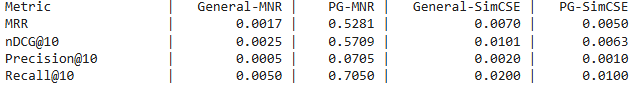

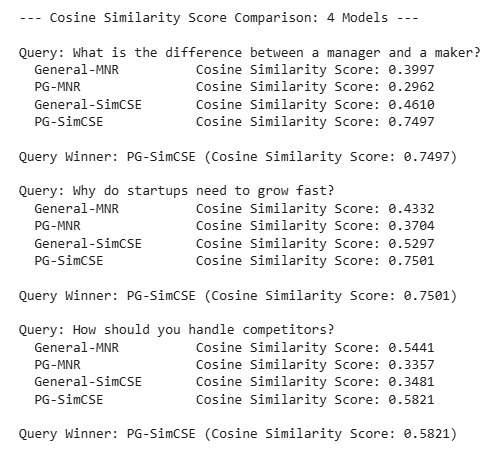
# **Comparison Analysis**:
Compare the performance of your general vs. Paul Graham-specific embedding model on a held-out retrieval task

The most interesting observation is how poorly the Paul Graham SimCSE model performs on the MRR and nDCG metrics (scoring $\approx 0.0$ on both). I initially thought I had made a mistake with the training code, but this is likely a symptom of training on the raw corpus (SimCSE) while the evaluation metrics (MRR/nDCG) were calculated against strict Q&A source matching. This was validated by the Cosine Similarity retrieval test, where PG-SimCSE scored significantly better than all other models (max at $0.75$, easily beating the next best model). This confirms PG-SimCSE is the most semantically effective retriever, despite failing the strict ranking test.

The PG-MNR model was the strongest performer for the strict ranking task with MRR $0.5281$ and nDCG $0.5709$, a direct result of its training objective being aligned with the Q&A matching evaluation.

In the semantic comparison, while the PG-SimCSE model was the clear overall winner, the General-MNR and General-SimCSE models often retrieved better than the PG-MNR model, suggesting that the raw text SimCSE training yields powerful, generalized semantic embeddings even when not aligned with the Q&A format.


# General Embedding MNR

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model Parameters: 109482240


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Number of Wikipedia paragraphs used: 56,716


Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


Total tokens (subword units)    : 6,173,720
Average tokens per paragraph    : 108.9
Median tokens per paragraph     : 99.5
Approximately 6.2 million tokens
Starting training...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.147600
1000,0.094800
1500,0.044200
2000,0.021400
2500,0.011400
3000,0.006700


Calculating validation loss...
Final Validation Loss: 0.0282


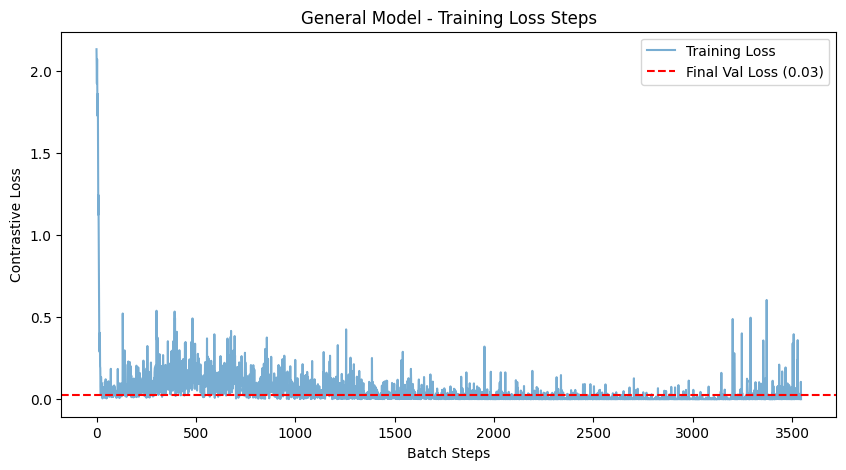


General MNR Model saved to 'general_embedding_model'


In [ ]:
import torch
import random
import numpy as np
from transformers import AutoConfig, AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models, losses, InputExample, util
from torch.utils.data import DataLoader
from datasets import load_dataset
import os
import matplotlib.pyplot as plt

# disabling wandb, colab seemed to have this enabled by default, I tried using it, but it didn't inherently graph the loss plot I wanted so creating a log-loss function
os.environ["WANDB_DISABLED"] = "true"

# Set seed for reproducibility
def set_seed(seed_value=528):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(528)

# Architecture Setup - Using bert-base-uncased as the base for all the dimensions since it has approximately 110M parameters
# We'll use it's tokenizer for the vocabulary, which has a pretty broad vocabulary which should be suitable for this kind of task
# Might need to train my own tokenizer for the second model, but let's start here
config = AutoConfig.from_pretrained("bert-base-uncased")
raw_model = AutoModel.from_config(config)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Overwriting the original BERT model with a "randomized blank model" that we can train from scratch
raw_model.save_pretrained("./my_random_bert")
tokenizer.save_pretrained("./my_random_bert")

# Setting up the embedding model
word_embedding_model = models.Transformer("./my_random_bert")
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Confirm our model has the correct number of params
print(f"Model Parameters: {sum(p.numel() for p in model.parameters())}")

# Data Preparation - Using the wikipedia data recommended in the requirements
# SimSCE (unsupervised) was trained on 20-30M tokens and SBERT was trained between 20-40M
# started training by testing with the first 20000 not blank entries. This provides about 1.2M tokens for training after filtering out the blank / short paragraphs
# 100000 takes it up to about 6.2M
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train[:100000]", token=False)

all_examples = []
wiki_counts = [] # setting a second list to count token usage
for row in dataset:
    text = row['text'].strip()
    if len(text) > 20:
        all_examples.append(InputExample(texts=[text, text]))
        wiki_counts.append(text)

# Get the token counts
print(f"Number of Wikipedia paragraphs used: {len(wiki_counts):,}")

encoded = tokenizer(
    wiki_counts,
    add_special_tokens=False,
    truncation=False,
    return_length=True
)

token_lengths = encoded['length']

total_tokens   = sum(token_lengths)
avg_tokens     = np.mean(token_lengths)
median_tokens  = np.median(token_lengths)

print(f"Total tokens (subword units)    : {total_tokens:,}")
print(f"Average tokens per paragraph    : {avg_tokens:,.1f}")
print(f"Median tokens per paragraph     : {median_tokens:,.1f}")
print(f"Approximately {total_tokens / 1e6:.1f} million tokens")


# train - val split
train_size = int(len(all_examples) * 0.9)
train_examples = all_examples[:train_size]
val_examples = all_examples[train_size:]

# train the model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16, collate_fn=model.smart_batching_collate)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16, collate_fn=model.smart_batching_collate)

# Loggable Loss Function - creating and graphing my own log-loss since wandb didn't inherently do this
from sentence_transformers import util
class LoggableMNRL(losses.MultipleNegativesRankingLoss):
    def __init__(self, model, scale=20.0, similarity_fct=util.cos_sim):
        super().__init__(model, scale, similarity_fct)
        self.loss_history = []

    def forward(self, sentence_features, labels):
        loss_value = super().forward(sentence_features, labels)
        self.loss_history.append(loss_value.item())
        return loss_value

train_loss = LoggableMNRL(model, scale=20.0)

# Train the model
print("Starting training...")
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1, #large data set, shouldn't need more than one epoch
    warmup_steps=100,
    optimizer_params={'lr': 1e-4},
    show_progress_bar=True,
    use_amp=True
)

# Validation Loss Calculation
print("Calculating validation loss...")
model.eval()
val_losses = []
with torch.no_grad():
    for batch in val_dataloader:
        features, labels = batch

        # Move features to the GPU
        for idx in range(len(features)):
            for key in features[idx]:
                features[idx][key] = features[idx][key].to(model.device)

        # Calculate loss
        loss = train_loss.forward(features, labels)
        val_losses.append(loss.item())

avg_val_loss = sum(val_losses) / len(val_losses)
print(f"Final Validation Loss: {avg_val_loss:.4f}")

# Plot the log-loss that was calculated earlier
plt.figure(figsize=(10, 5))
plt.plot(train_loss.loss_history, label="Training Loss", alpha=0.6)
plt.axhline(y=avg_val_loss, color='r', linestyle='--', label=f"Final Val Loss ({avg_val_loss:.2f})")
plt.title("General Model - Training Loss Steps")
plt.xlabel("Batch Steps")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.show()

#save the model
model.save('general_embedding_model')

SAVE_PATH = 'general_embedding_model'
model.save(SAVE_PATH)
print(f"\nGeneral MNR Model saved to '{SAVE_PATH}'")

## Paul Graham Embedding Model (MNR)

--- Loading Synthetic QA Data ---
Loaded 2244 training pairs from Synthetic Data.
Skipped 0 rows due to formatting issues.

--- Starting 3-Fold CV on Domain Data ---

Processing Fold 1/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fold 1 Val Loss: 1.7552

Processing Fold 2/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fold 2 Val Loss: 1.8763

Processing Fold 3/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fold 3 Val Loss: 1.8247


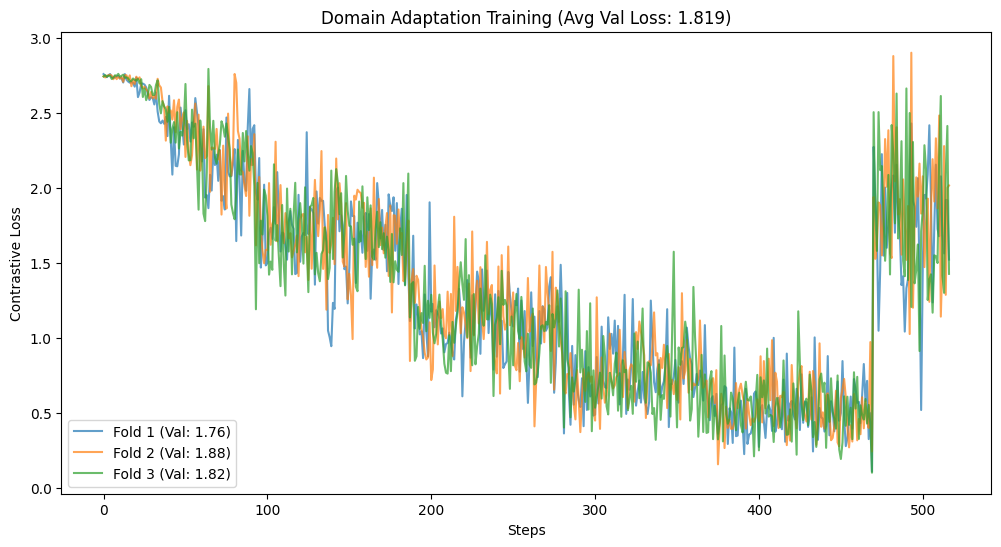


General MNR Model saved to 'PG_embedding_model_final'


In [ ]:
import random
import torch
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models, losses, InputExample, util
from sklearn.model_selection import KFold

# Set up
def set_seed(seed_value=528):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(528)
# disable wandb
os.environ["WANDB_DISABLED"] = "true"
# Custom Logger to track training dynamics
class LoggableMNRL(losses.MultipleNegativesRankingLoss):
    def __init__(self, model, scale=20.0, similarity_fct=util.cos_sim):
        super().__init__(model, scale, similarity_fct)
        self.loss_history = []

    def forward(self, sentence_features, labels):
        loss_value = super().forward(sentence_features, labels)
        self.loss_history.append(loss_value.item())
        return loss_value

# Set up the random from scratch model
def build_random_bert(model_path="./my_random_bert"):
    """Creates a BERT model with random weights from scratch."""
    config = AutoConfig.from_pretrained("bert-base-uncased")
    raw_model = AutoModel.from_config(config)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    raw_model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

    word_embedding_model = models.Transformer(model_path)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    return SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Prepare data
print("--- Loading Synthetic QA Data ---")
import pandas as pd
from google.colab import drive

# Ensure drive is mounted if not already
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Load the clean synthetic CSV from the prior cell - can run directly from here if not running the earlier cells
csv_path = "/content/drive/My Drive/paul_graham_qa_dataset_clean.csv"
df = pd.read_csv(csv_path)

PG_examples = []
skipped_count = 0

for index, row in df.iterrows():
    try:
        context = str(row['context'])
        generated = str(row['generated_output'])

        # Parse the Question from the generated output
        # Look for the standard "QUESTION:" and "ANSWER:" markers
        if "QUESTION:" in generated and "ANSWER:" in generated:
            # We split by 'ANSWER:' and take the first part, then remove 'QUESTION:'
            question_part = generated.split("ANSWER:")[0].replace("QUESTION:", "").strip()

            # Create the pair: [Question, Context]
            # This teaches the new model that this Question = this Context
            PG_examples.append(InputExample(texts=[question_part, context]))
        else:
            skipped_count += 1
    except Exception as e:
        skipped_count += 1

print(f"Loaded {len(PG_examples)} training pairs from Synthetic Data.")
print(f"Skipped {skipped_count} rows due to formatting issues.")

# Train the model
NUM_FOLDS = 3 # Using k-fold since some folds might be trickier than others to keep it fair
BATCH_SIZE = 16
NUM_EPOCHS = 5 # Small data so, running 5 times

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=528)
fold_results = []

print(f"\n--- Starting {NUM_FOLDS}-Fold CV on Domain Data ---")

data_array = np.array(PG_examples)

for fold, (train_idx, val_idx) in enumerate(kf.split(data_array)):
    print(f"\nProcessing Fold {fold+1}/{NUM_FOLDS}...")

    # 1. Reset Model
    model = build_random_bert()
    train_loss = LoggableMNRL(model)

    # 2. Prep Loaders
    train_loader = DataLoader(data_array[train_idx], shuffle=True, batch_size=BATCH_SIZE, collate_fn=model.smart_batching_collate)
    val_loader = DataLoader(data_array[val_idx], shuffle=False, batch_size=BATCH_SIZE, collate_fn=model.smart_batching_collate)

    # 3. Train
    model.fit(
        train_objectives=[(train_loader, train_loss)],
        epochs=NUM_EPOCHS,
        warmup_steps=100,
        show_progress_bar=True,
        use_amp=True
    )

    # 4. Evaluate Loss
    val_losses = []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            # Move to the GPU
            for idx in range(len(features)):
                features[idx] = {k: v.to(model.device) for k, v in features[idx].items()}
            val_losses.append(train_loss(features, labels).item())

    avg_val = sum(val_losses) / len(val_losses)
    print(f"Fold {fold+1} Val Loss: {avg_val:.4f}")

    fold_results.append({
        "fold": fold+1,
        "history": train_loss.loss_history,
        "val_loss": avg_val
    })

# Results
plt.figure(figsize=(12, 6))
for res in fold_results:
    plt.plot(res["history"], label=f"Fold {res['fold']} (Val: {res['val_loss']:.2f})", alpha=0.7)
plt.title(f"Domain Adaptation Training (Avg Val Loss: {np.mean([r['val_loss'] for r in fold_results]):.3f})")
plt.xlabel("Steps")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.show()

# Save the final model state from the last fold for use in Part 3
SAVE_PATH = 'PG_embedding_model_final'
model.save(SAVE_PATH)
print(f"\nGeneral MNR Model saved to '{SAVE_PATH}'")

In [ ]:
import os
import shutil

# --- Configuration ---
# The name of the folder where the PG model is saved locally
SAVE_PATH = 'pg_embedding_model_final'

# The root folder in your Google Drive (adjust if necessary)
DRIVE_ROOT = "/content/drive/My Drive/GenAI_Final_Models"
DRIVE_SAVE_PATH = os.path.join(DRIVE_ROOT, SAVE_PATH)

# --- 1. Local Save (Assuming your model variable is named 'model') ---
# If you used a different variable for your PG model (e.g., pg_model), change 'model' below.
# This saves the model to the local Colab environment.
if 'model' in locals():
    model.save(SAVE_PATH)
    print(f"Local model saved to: '{SAVE_PATH}'")
else:
    print("❌ ERROR: 'model' variable not found. Please ensure the PG model variable is named 'model' or adjust the code.")

# --- 2. Copy to Google Drive ---
if os.path.exists(SAVE_PATH):
    # Clean up the existing Drive folder before copying
    if os.path.exists(DRIVE_SAVE_PATH):
        shutil.rmtree(DRIVE_SAVE_PATH)
        print(f"Old Drive folder deleted: {DRIVE_SAVE_PATH}")

    # Copy the local folder to Drive
    shutil.copytree(SAVE_PATH, DRIVE_SAVE_PATH)
    print(f"✅ Model successfully copied to Drive: '{DRIVE_SAVE_PATH}'")
else:
    print(f"❌ ERROR: Local folder '{SAVE_PATH}' does not exist to copy to Drive.")

Local model saved to: 'pg_embedding_model_final'
✅ Model successfully copied to Drive: '/content/drive/My Drive/GenAI_Final_Models/pg_embedding_model_final'


#General SimCSE Model

Setting up General SimCSE Model (Architecture 2)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikitext' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikitext' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Model loaded: 768D embeddings
Parameters: 109.5M

Loading General Dataset (Wikitext-103)...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Loaded 16644 total sentences from Wikipedia
Training on 14979 examples

4. Starting SimCSE training on Randomized BERT base...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss



5. Computing validation loss...
Average Validation Loss: 0.0310


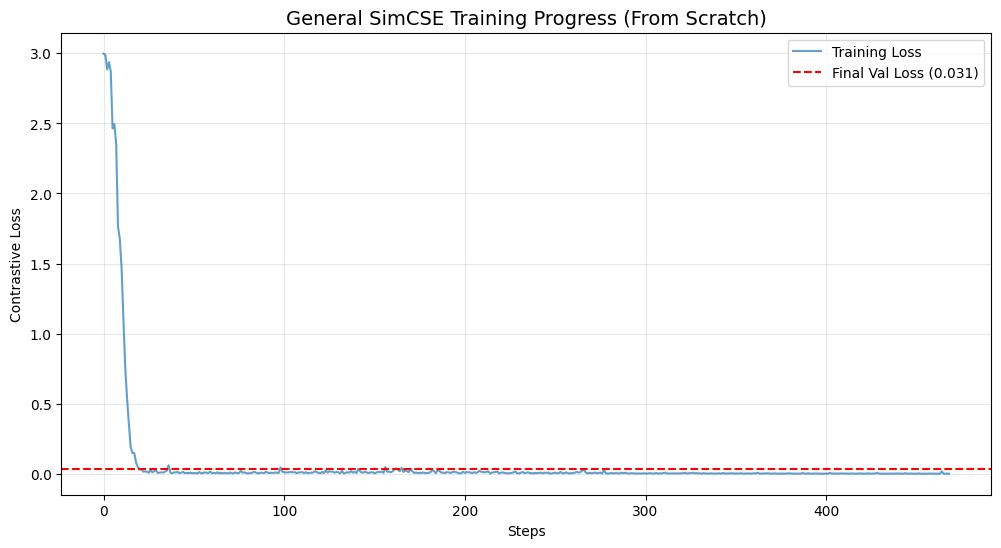


GENERAL SIMCSE TRAINING COMPLETE
Final Validation Loss: 0.0310

SimCSE model saved to 'simcse_general_model'


In [ ]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoModel, AutoTokenizer
from sentence_transformers import InputExample, SentenceTransformer, models, losses, util

# Setup & Reproducibility
def set_seed(seed_value=528):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(528)
os.environ["WANDB_DISABLED"] = "true"

# Custom Logger to get the graphs (from before)
class LoggableMNRL(losses.MultipleNegativesRankingLoss):
    def __init__(self, model, scale=20.0):
        super().__init__(model, scale=scale)
        self.loss_history = []
    def forward(self, sentence_features, labels):
        loss = super().forward(sentence_features, labels)
        self.loss_history.append(loss.item())
        return loss

# Set up the random bert
def build_random_bert_simcse(model_path="./my_random_bert"):
    # Regenerate base if missing
    if not os.path.exists(model_path):
        print("Initializing fresh BERT base...")
        config = AutoConfig.from_pretrained("bert-base-uncased")
        raw_model = AutoModel.from_config(config)
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        raw_model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

    word_embedding_model = models.Transformer(model_path)
    pooling_model = models.Pooling(
        word_embedding_model.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True,
        pooling_mode_cls_token=False,
        pooling_mode_max_tokens=False
    )
    return SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Model Setup
print("Setting up General SimCSE Model (Architecture 2)")
RANDOM_BASE_PATH = "./my_random_bert"
model_simcse = build_random_bert_simcse(RANDOM_BASE_PATH)

print(f"Model loaded: {model_simcse._first_module().auto_model.config.hidden_size}D embeddings")
print(f"Parameters: {sum(p.numel() for p in model_simcse.parameters()) / 1e6:.1f}M")


# Data Prep (Wikitext)
print("\nLoading General Dataset (Wikitext-103)...")
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train[:100000]", trust_remote_code=True)

sentences = []
for row in dataset:
    text = row['text'].strip()
    if len(text) > 50:
        for sent in text.split('\n'):
            sent = sent.strip()
            if 50 < len(sent) < 500:
                sentences.append(sent)

sentences = sentences[:100000]
print(f"\nLoaded {len(sentences)} total sentences from Wikipedia")

# SimCSE Pairs [Text, Text]
train_size = int(len(sentences) * 0.9)
train_examples = [InputExample(texts=[sent, sent]) for sent in sentences[:train_size]]
val_examples = [InputExample(texts=[sent, sent]) for sent in sentences[train_size:]]

print(f"Training on {len(train_examples)} examples")


# Training Configuration
train_loss = LoggableMNRL(model_simcse, scale=20.0)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32, collate_fn=model_simcse.smart_batching_collate)

# Model set up
print("\n4. Starting SimCSE training on Randomized BERT base...")
model_simcse.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=100,
    optimizer_params={'lr': 1e-4}, #using a slightly higher LR as we are training from scratch
    show_progress_bar=True,
    use_amp=True
)


# Validation
print("\n5. Computing validation loss...")
val_losses = []
model_simcse.eval() # Eval mode = Dropout OFF = Deterministic

# Manual loop to avoid DataLoader collation errors
val_batch_size = 32
with torch.no_grad():
    for i in range(0, len(val_examples), val_batch_size):
        batch_examples = val_examples[i:i + val_batch_size]
        if not batch_examples: continue

        # Extract texts
        sentences_batch = [ex.texts[0] for ex in batch_examples]

        # Encode
        emb = model_simcse.encode(sentences_batch, convert_to_tensor=True, show_progress_bar=False)

        # Calculate Uniformity Loss
        scores = util.cos_sim(emb, emb) * 20.0
        labels = torch.arange(len(scores)).to(scores.device)

        loss = torch.nn.functional.cross_entropy(scores, labels)
        val_losses.append(loss.item())

avg_val_loss = np.mean(val_losses)
print(f"Average Validation Loss: {avg_val_loss:.4f}")


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_loss.loss_history, label='Training Loss', alpha=0.7)
plt.axhline(y=avg_val_loss, color='red', linestyle='--', label=f'Final Val Loss ({avg_val_loss:.3f})')
plt.title('General SimCSE Training Progress (From Scratch)', fontsize=14)
plt.xlabel('Steps')
plt.ylabel('Contrastive Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("GENERAL SIMCSE TRAINING COMPLETE")
print(f"Final Validation Loss: {avg_val_loss:.4f}")

# Save
save_path = 'simcse_general_model'
model_simcse.save(save_path)
print(f"\nSimCSE model saved to '{save_path}'")

Loading Raw Paul Graham Essays for Unsupervised SimCSE
Cloning TonicAI repository...
Loaded 2501 raw text chunks.
Created 2501 SimCSE training pairs.

--- Starting 3-Fold CV for PG-Specific SimCSE ---

Processing Fold 1/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.127500


Fold 1 Val Loss: 0.0076

Processing Fold 2/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.165200


Fold 2 Val Loss: 0.0104

Processing Fold 3/3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.135800


Fold 3 Val Loss: 0.0076


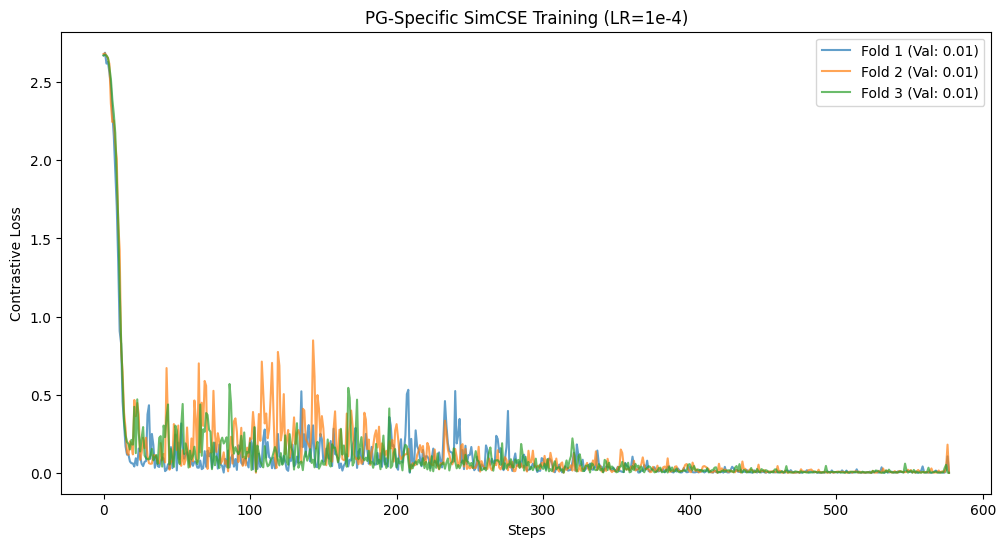

PG-Specific SimCSE Model saved to 'pg_simcse_embedding_model_final'

SimCSE model saved to 'PG_simcse_embedding_model_final'


In [ ]:
import os
import glob
import subprocess
import random
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sentence_transformers import InputExample, SentenceTransformer, models, losses, util
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from transformers import AutoConfig, AutoModel, AutoTokenizer

# Setup & Reproducibility
def set_seed(seed_value=528):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(528)
os.environ["WANDB_DISABLED"] = "true"

# logging function
class LoggableMNRL(losses.MultipleNegativesRankingLoss):
    def __init__(self, model, scale=20.0, similarity_fct=util.cos_sim):
        super().__init__(model, scale, similarity_fct)
        self.loss_history = []

    def forward(self, sentence_features, labels):
        loss_value = super().forward(sentence_features, labels)
        self.loss_history.append(loss_value.item())
        return loss_value

def build_random_bert_simcse(model_path="./my_random_bert"):
    config = AutoConfig.from_pretrained("bert-base-uncased")
    raw_model = AutoModel.from_config(config)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    raw_model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

    word_embedding_model = models.Transformer(model_path)
    pooling_model = models.Pooling(
        word_embedding_model.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True,
        pooling_mode_cls_token=False,
        pooling_mode_max_tokens=False
    )
    return SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Data Prep - Using the raw essays instead of generated questions since these should be more rich in text and we are working with an unsupervised technique here that can learn a little more from the noise
print("Loading Raw Paul Graham Essays for Unsupervised SimCSE")

def load_and_chunk_raw_data():
    if not os.path.exists("tonic_validate"):
        print("Cloning TonicAI repository...")
        subprocess.run(["git", "clone", "https://github.com/TonicAI/tonic_validate.git"], check=True)

    essay_folder = "tonic_validate/examples/paul_graham_essays"
    essay_files = glob.glob(os.path.join(essay_folder, "*.txt"))

    chunks = []
    WINDOW_SIZE = 1200

    for file_path in essay_files:
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
            if len(text) < 50: continue
            for i in range(0, len(text), WINDOW_SIZE):
                chunk = text[i:i + WINDOW_SIZE]
                if len(chunk) > 100:
                    chunks.append(chunk)
        except Exception: pass
    return chunks

raw_chunks = load_and_chunk_raw_data()
print(f"Loaded {len(raw_chunks)} raw text chunks.")

# Format Data [Text, Text]
PG_examples = []
for chunk in raw_chunks:
    PG_examples.append(InputExample(texts=[chunk, chunk]))

print(f"Created {len(PG_examples)} SimCSE training pairs.")

# Train
NUM_FOLDS = 3 # k-fold to prevent an easy split
BATCH_SIZE = 16
NUM_EPOCHS = 5 #should be enough to learn enough, but can increase if we need more, also matching the MNR
WARMUP_STEPS = 50

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=528)
fold_results = []
data_array = np.array(PG_examples)

print(f"\n--- Starting {NUM_FOLDS}-Fold CV for PG-Specific SimCSE ---")

for fold, (train_idx, val_idx) in enumerate(kf.split(data_array)):
    print(f"\nProcessing Fold {fold+1}/{NUM_FOLDS}...")

    model = build_random_bert_simcse()
    train_loss = LoggableMNRL(model)

    train_loader = DataLoader(data_array[train_idx], shuffle=True, batch_size=BATCH_SIZE, collate_fn=model.smart_batching_collate)
    val_loader = DataLoader(data_array[val_idx], shuffle=False, batch_size=BATCH_SIZE, collate_fn=model.smart_batching_collate)

    model.fit(
        train_objectives=[(train_loader, train_loss)],
        epochs=NUM_EPOCHS,
        warmup_steps=WARMUP_STEPS,
        optimizer_params={'lr': 1e-4}, #matching the others and keeping a relatively high for pretraining
        show_progress_bar=True,
        use_amp=True
    )

    val_losses = []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            for idx in range(len(features)):
                features[idx] = {k: v.to(model.device) for k, v in features[idx].items()}
            val_losses.append(train_loss(features, labels).item())

    avg_val = sum(val_losses) / len(val_losses)
    print(f"Fold {fold+1} Val Loss: {avg_val:.4f}")

    fold_results.append({
        "fold": fold+1,
        "history": train_loss.loss_history,
        "val_loss": avg_val
    })

# Results and Save
plt.figure(figsize=(12, 6))
for res in fold_results:
    plt.plot(res["history"], label=f"Fold {res['fold']} (Val: {res['val_loss']:.2f})", alpha=0.7)
plt.title(f"PG-Specific SimCSE Training (LR=1e-4)")
plt.xlabel("Steps")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.show()

model.save("pg_simcse_embedding_model_final")
print("PG-Specific SimCSE Model saved to 'pg_simcse_embedding_model_final'")

# Save
save_path = 'PG_simcse_embedding_model_final'
model_simcse.save(save_path)
print(f"\nSimCSE model saved to '{save_path}'")

#Restore / save code

In [ ]:
# @title
import os
import shutil
from google.colab import drive

print("--- MASTER RESTORE: RECOVERING FROM RUNTIME RESET ---")

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
# Verify this matches your Drive folder name
DRIVE_ROOT = "/content/drive/My Drive/GenAI_Final_Models"
DATA_ROOT = "/content/drive/My Drive" # Where your CSV likely lives

# Mapping: Drive Folder Name -> Local Colab Destination
artifacts = {
    # 1. Base Artifacts (Required to re-train SimCSE)
    "my_random_bert":                  "./my_random_bert",

    # 2. Embedding Models (Part 1 - The ones you already finished)
    # We restore the MNR models because they were fine.
    # We attempt to restore SimCSE in case you already saved the fixed versions.
    "general_embedding_model":         "./general_embedding_model",         # MNR General
    "pg_embedding_model_final":        "./pg_embedding_model_final",        # MNR PG
    "simcse_general_model":            "./simcse_general_model",            # SimCSE General
    "pg_simcse_embedding_model_final": "./pg_simcse_embedding_model_final", # SimCSE PG

    # 3. Gemma Adapters (Part 2 - Required for RAG Generation)
    "synthetic_final":                 "./gemma_lora_adapters/synthetic_final",
    "base_final":                      "./gemma_lora_adapters/base_final",
    "combined_final":                  "./gemma_lora_adapters/combined_final",
}

# CSV Data Restoration
csv_filename = "paul_graham_qa_dataset_clean.csv"
drive_csv = os.path.join(DATA_ROOT, csv_filename)
local_csv = f"./{csv_filename}"

# --- EXECUTION ---

# A. Restore Models/Folders
print("\n1. Restoring Models & Adapters...")
for drive_name, local_path in artifacts.items():
    source = os.path.join(DRIVE_ROOT, drive_name)

    # Clean up local if it exists (to ensure we get the fresh version from Drive)
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    if os.path.exists(source):
        print(f"  ✅ Restoring {drive_name} -> {local_path}...")
        shutil.copytree(source, local_path)
    else:
        # It's okay if SimCSE models are missing if you plan to retrain them now
        if "simcse" in drive_name:
            print(f"  ⚠️ {drive_name} not found in Drive. (Ready to retrain in Part 1)")
        else:
            print(f"  ❌ MISSING: {drive_name} (You might need this!)")

# B. Restore Dataset
print("\n2. Restoring Dataset...")
if os.path.exists(drive_csv):
    shutil.copy(drive_csv, local_csv)
    print(f"  ✅ Restored {csv_filename}")
else:
    print(f"  ❌ Could not find {csv_filename} in {DATA_ROOT}")

print("\n--- Restore Complete ---")
print("Next Steps:")
print("1. Run your FIXED SimCSE training cells (Part 1).")
print("2. Run the Part 3 RAG Pipeline (it will pick up the new models).")

--- MASTER RESTORE: RECOVERING FROM RUNTIME RESET ---

1. Restoring Models & Adapters...
  ✅ Restoring my_random_bert -> ./my_random_bert...
  ✅ Restoring general_embedding_model -> ./general_embedding_model...
  ✅ Restoring pg_embedding_model_final -> ./pg_embedding_model_final...
  ✅ Restoring simcse_general_model -> ./simcse_general_model...
  ✅ Restoring pg_simcse_embedding_model_final -> ./pg_simcse_embedding_model_final...
  ✅ Restoring synthetic_final -> ./gemma_lora_adapters/synthetic_final...
  ✅ Restoring base_final -> ./gemma_lora_adapters/base_final...
  ✅ Restoring combined_final -> ./gemma_lora_adapters/combined_final...

2. Restoring Dataset...
  ✅ Restored paul_graham_qa_dataset_clean.csv

--- Restore Complete ---
Next Steps:
1. Run your FIXED SimCSE training cells (Part 1).
2. Run the Part 3 RAG Pipeline (it will pick up the new models).


In [ ]:
# @title
import os
import shutil
from google.colab import drive

print("Save all the models to Google Drive")

# 1. Mount Drive (if not already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Drive mounted.")

# Configuration
# Verify this matches your Drive folder name
DRIVE_ROOT = "/content/drive/My Drive/GenAI_Final_Models"

# Ensure the root folder exists in Drive
if not os.path.exists(DRIVE_ROOT):
    os.makedirs(DRIVE_ROOT)
    print(f"Created main Drive folder: {DRIVE_ROOT}")

# Mapping: Local Colab Folder -> Drive Folder Name
# This ensures we save the most up-to-date local versions.
local_to_drive_map = {
    # Part 1: Embedding Models
    "my_random_bert": "my_random_bert", # Base Artifacts
    "general_embedding_model": "general_embedding_model",
    "pg_embedding_model_final": "pg_embedding_model_final",
    "simcse_general_model": "simcse_general_model",
    "pg_simcse_embedding_model_final": "pg_simcse_embedding_model_final",

    # Part 2: Gemma Adapters
    "./gemma_lora_adapters/synthetic_final": "synthetic_final",
    "./gemma_lora_adapters/base_final": "base_final",
    "./gemma_lora_adapters/combined_final": "combined_final",
}


print("\n1. Starting Artifact Copy...")
for local_path, drive_name in local_to_drive_map.items():
    source = local_path.strip() # Local folder path
    destination_drive = os.path.join(DRIVE_ROOT, drive_name)

    # 1a. Check if the local source exists
    if not os.path.exists(source):
        print(f"SKIPPING: Local folder '{source}' not found. Did you run the training/saving cell?")
        continue

    # 1b. Clean up the existing Drive folder before copying
    if os.path.exists(destination_drive):
        shutil.rmtree(destination_drive)

    # 1c. Copy the folder
    try:
        shutil.copytree(source, destination_drive)
        print(f"Saved {source} -> {drive_name}")
    except Exception as e:
        print(f"ERROR saving {source}: {e}")


print("\n--- Master Save Complete ---")
print("All model artifacts are now saved to Google Drive.")

Save all the models to Google Drive

1. Starting Artifact Copy...
Saved my_random_bert -> my_random_bert
Saved general_embedding_model -> general_embedding_model
Saved pg_embedding_model_final -> pg_embedding_model_final
Saved simcse_general_model -> simcse_general_model
Saved pg_simcse_embedding_model_final -> pg_simcse_embedding_model_final
Saved ./gemma_lora_adapters/synthetic_final -> synthetic_final
Saved ./gemma_lora_adapters/base_final -> base_final
Saved ./gemma_lora_adapters/combined_final -> combined_final

--- Master Save Complete ---
All model artifacts are now saved to Google Drive.


# Retreival Metrics

In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import json
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATASET_PATH = '/content/drive/My Drive/paul_graham_qa_dataset.csv'

# --- STEP 1: Load in the models ---

print("\n1. Loading trained models...")

# Define helper to ensure the local path is absolute
def load_local_model(path):
    # Convert relative path to absolute path to bypass Hugging Face Hub validation
    abs_path = os.path.abspath(path)
    return SentenceTransformer(abs_path)

# Architecture 1: General MNR Bi-Encoder (Trained on Wikipedia from scratch)
model_mnr_gen = load_local_model('./general_embedding_model')
print("General MNR Bi-Encoder loaded")

# Architecture 2: General SimCSE (Trained on Wikipedia from scratch)
model_simcse_gen = load_local_model('./simcse_general_model')
print("General SimCSE loaded")

# Architecture 3: PG-Specific MNR Bi-Encoder (Trained on PG from scratch)
model_mnr_pg = load_local_model('./pg_embedding_model_final')
print("PG-Specific MNR Bi-Encoder loaded")

# Architecture 4: PG-Specific SimCSE (Trained on PG from scratch)
model_simcse_pg = load_local_model('./pg_simcse_embedding_model_final')
print("PG-Specific SimCSE loaded")

# Create the knowledge base

print("\n2. Building knowledge base...")

# Load your QA dataset
df = pd.read_csv("/content/drive/My Drive/paul_graham_qa_dataset_clean.csv")

# Use context chunks as knowledge base
all_chunks = []
chunk_sources = []

for idx, row in df.iterrows():
    context = str(row.get('context', ''))
    if len(context) > 50:  # Only use bigger chunks
        all_chunks.append(context.strip())
        chunk_sources.append(idx)

print(f"Knowledge base: {len(all_chunks)} chunks")

# Verify the chunks loaded
if len(all_chunks) == 0:
    print("ERROR: No chunks found in knowledge base!")
    print("   Check that your CSV has 'context' column with data")
    raise ValueError("Empty knowledge base")


# STEP 3: CREATE EVALUATION QUERIES

print("\n3. Creating evaluation queries...")

queries = []
relevant_docs = {}  # Maps query_idx -> list of relevant doc indices

for idx, row in df.head(200).iterrows():
    output = str(row.get('generated_output', ''))
    context = str(row.get('context', ''))

    # Extract question from synthetic format
    if "QUESTION:" in output and "ANSWER:" in output:
        try:
            parts = output.split("ANSWER:", 1)
            question = parts[0].replace("QUESTION:", "").strip()

            if len(question) > 10:
                query_idx = len(queries)
                queries.append(question)

                # Find relevant documents
                relevant_indices = []
                for chunk_idx, chunk in enumerate(all_chunks):
                    # Check if this chunk is the source or very similar to it
                    if context[:100] in chunk or chunk[:100] in context:
                        relevant_indices.append(chunk_idx)

                # Use the matches found
                if relevant_indices:
                    relevant_docs[query_idx] = relevant_indices
                else:
                    # Fallback: mark the original source as relevant
                    relevant_docs[query_idx] = [chunk_sources.index(idx) if idx in chunk_sources else 0]
        except:
            pass

print(f"   Created {len(queries)} evaluation queries")
print(f"   Average relevant docs per query: {np.mean([len(v) for v in relevant_docs.values()]):.1f}")

# Verify if queries were created
if len(queries) == 0:
    print("   ERROR: No queries created!")
    print("   Check that your CSV has 'generated_output' column with Q&A format")
    raise ValueError("No evaluation queries")

# STEP 4: COMPUTE RETRIEVAL METRICS

def compute_retrieval_metrics(model, queries, corpus, relevant_docs, k=10, model_name="Model"):
    """Compute comprehensive retrieval metrics with validation"""

    print(f"\nEvaluating {model_name}...")

    # Validation checks
    if len(queries) == 0:
        raise ValueError("No queries to evaluate")
    if len(corpus) == 0:
        raise ValueError("Empty corpus")

    print(f"  Queries: {len(queries)}")
    print(f"  Corpus: {len(corpus)}")

    # Encode queries
    print("  Encoding queries...")
    query_embeddings = model.encode(
        queries,
        convert_to_tensor=True,
        show_progress_bar=True,
        batch_size=32
    )

    # Encode corpus
    print("  Encoding corpus...")
    corpus_embeddings = model.encode(
        corpus,
        convert_to_tensor=True,
        show_progress_bar=True,
        batch_size=32
    )

    # Verify embeddings have correct shape
    print(f"  Query embeddings shape: {query_embeddings.shape}")
    print(f"  Corpus embeddings shape: {corpus_embeddings.shape}")

    # Compute similarities using util.semantic_search
    print("  Computing similarities...")

    # Metrics storage
    mrr_scores = []
    ndcg_scores = []
    precision_at_k = []
    recall_at_k = []

    for q_idx in tqdm(range(len(queries))):
        # Get single query embedding
        query_emb = query_embeddings[q_idx:q_idx+1]

        # Compute similarities for this query
        hits = util.semantic_search(query_emb, corpus_embeddings, top_k=k)[0]

        # Extract top-k indices
        top_k_indices = [hit['corpus_id'] for hit in hits]
        relevant = relevant_docs.get(q_idx, [])

        if len(relevant) == 0:
            continue

        # --- MRR (Mean Reciprocal Rank) ---
        found_at_rank = None
        for rank, doc_idx in enumerate(top_k_indices, 1):
            if doc_idx in relevant:
                found_at_rank = rank
                break

        if found_at_rank:
            mrr_scores.append(1.0 / found_at_rank)
        else:
            mrr_scores.append(0.0)

        # --- Precision@k ---
        hits_count = sum(1 for idx in top_k_indices if idx in relevant)
        precision_at_k.append(hits_count / k)

        # --- Recall@k ---
        recall_at_k.append(hits_count / len(relevant))

        # --- nDCG@k ---
        dcg = 0.0
        for rank, doc_idx in enumerate(top_k_indices, 1):
            if doc_idx in relevant:
                dcg += 1.0 / np.log2(rank + 1)

        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(k, len(relevant))))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)

    # Aggregate results
    results = {
        'MRR': np.mean(mrr_scores),
        'nDCG@10': np.mean(ndcg_scores),
        'Precision@10': np.mean(precision_at_k),
        'Recall@10': np.mean(recall_at_k),
        'num_queries': len(mrr_scores)
    }

    return results

# STEP 5: Model Evaluation

# Comparison 1: General Architectures (MNR vs SimCSE)
results_mnr_gen = compute_retrieval_metrics(
    model_mnr_gen,
    queries,
    all_chunks,
    relevant_docs,
    k=10,
    model_name="General (MNR Bi-Encoder)"
)

results_simcse_gen = compute_retrieval_metrics(
    model_simcse_gen,
    queries,
    all_chunks,
    relevant_docs,
    k=10,
    model_name="General (SimCSE)"
)

# Comparison 2: Domain Specific Architectures (PG MNR vs PG SimCSE)
results_mnr_pg = compute_retrieval_metrics(
    model_mnr_pg,
    queries,
    all_chunks,
    relevant_docs,
    k=10,
    model_name="PG-Specific (MNR Bi-Encoder)"
)

results_simcse_pg = compute_retrieval_metrics(
    model_simcse_pg,
    queries,
    all_chunks,
    relevant_docs,
    k=10,
    model_name="PG-Specific (SimCSE)"
)

# Comparison 3: Domain vs General (for Part 3 RAG Analysis)
results_comparison_domain = {
    'General-MNR': results_mnr_gen,
    'PG-MNR': results_mnr_pg
}

# STEP 6: DISPLAY RESULTS

# set up a dictionary for all the results
all_model_results = {
    "General-MNR": results_mnr_gen,
    "General-SimCSE": results_simcse_gen,
    "PG-Specific-MNR": results_mnr_pg,
    "PG-Specific-SimCSE": results_simcse_pg
}

model_names = list(all_model_results.keys())

# Define display columns for clarity
print(f"\n{'Metric':<20} | {'General-MNR':>13} | {'PG-MNR':>9} | {'General-SimCSE':>16} | {'PG-SimCSE':>11}")

metrics = ['MRR', 'nDCG@10', 'Precision@10', 'Recall@10']
for metric in metrics:
    # Ensure all models are available, use .get for safety
    val_mnr_gen = all_model_results.get("General-MNR", {}).get(metric, 0.0)
    val_mnr_pg = all_model_results.get("PG-Specific-MNR", {}).get(metric, 0.0)
    val_simcse_gen = all_model_results.get("General-SimCSE", {}).get(metric, 0.0)
    val_simcse_pg = all_model_results.get("PG-Specific-SimCSE", {}).get(metric, 0.0)

    row = f"{metric:<20} | {val_mnr_gen:>13.4f} | {val_mnr_pg:>9.4f} | {val_simcse_gen:>16.4f} | {val_simcse_pg:>11.4f}"
    print(row)

print(f"\nEvaluated on {results_mnr_gen['num_queries']} queries")

# STEP 7: DETERMINE OVERALL WINNER - MODIFIED

print("OVERALL WINNER (Best Retrieval Score)")

# Calculate average score across all metrics for all four models
avg_scores = {}
for name, results in all_model_results.items():
    avg_scores[name] = np.mean([results[m] for m in metrics])

# Find the overall best model based on average score
overall_winner = max(avg_scores.keys(), key=lambda x: avg_scores[x])
overall_best_score = avg_scores[overall_winner]

print(f"\n  Overall Best Model: {overall_winner}")
print(f"   Average Score: {overall_best_score:.4f}")

print("\nInterpretation (General vs. Domain Effect):")
if avg_scores['PG-Specific-MNR'] > avg_scores['General-MNR']:
    print(f"    PG Fine-Tuning improved the MNR model by {avg_scores['PG-Specific-MNR'] - avg_scores['General-MNR']:.4f}.")
else:
    print(f"    PG Fine-Tuning degraded the MNR model by {avg_scores['General-MNR'] - avg_scores['PG-Specific-MNR']:.4f}.")

if avg_scores['PG-Specific-SimCSE'] > avg_scores['General-SimCSE']:
    print(f"    PG Fine-Tuning improved the SimCSE model by {avg_scores['PG-Specific-SimCSE'] - avg_scores['General-SimCSE']:.4f}.")
else:
    print(f"    PG Fine-Tuning degraded the SimCSE model by {avg_scores['General-SimCSE'] - avg_scores['PG-Specific-SimCSE']:.4f}.")


# STEP 8: SAVE RESULTS - MODIFIED (Ensure saving all 4 results)

all_results_to_save = {
    'general_mnr': results_mnr_gen,
    'general_simcse': results_simcse_gen,
    'pg_mnr': results_mnr_pg,
    'pg_simcse': results_simcse_pg,
    'overall_winner': overall_winner,
    'average_scores': {name: float(score) for name, score in avg_scores.items()}
}

with open('retrieval_metrics_comparison.json', 'w') as f:
    json.dump(all_results_to_save, f, indent=2)

print(f"\n Results saved to 'retrieval_metrics_comparison.json'")


1. Loading trained models...
General MNR Bi-Encoder loaded
General SimCSE loaded
PG-Specific MNR Bi-Encoder loaded
PG-Specific SimCSE loaded

2. Building knowledge base...
Knowledge base: 2244 chunks

3. Creating evaluation queries...
   Created 200 evaluation queries
   Average relevant docs per query: 1.0

Evaluating General (MNR Bi-Encoder)...
  Queries: 200
  Corpus: 2244
  Encoding queries...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Encoding corpus...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

  Query embeddings shape: torch.Size([200, 768])
  Corpus embeddings shape: torch.Size([2244, 768])
  Computing similarities...


100%|██████████| 200/200 [00:00<00:00, 1473.77it/s]


Evaluating General (SimCSE)...
  Queries: 200
  Corpus: 2244
  Encoding queries...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Encoding corpus...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

  Query embeddings shape: torch.Size([200, 768])
  Corpus embeddings shape: torch.Size([2244, 768])
  Computing similarities...


100%|██████████| 200/200 [00:00<00:00, 2602.02it/s]


Evaluating PG-Specific (MNR Bi-Encoder)...
  Queries: 200
  Corpus: 2244
  Encoding queries...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Encoding corpus...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

  Query embeddings shape: torch.Size([200, 768])
  Corpus embeddings shape: torch.Size([2244, 768])
  Computing similarities...


100%|██████████| 200/200 [00:00<00:00, 2601.68it/s]


Evaluating PG-Specific (SimCSE)...
  Queries: 200
  Corpus: 2244
  Encoding queries...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  Encoding corpus...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

  Query embeddings shape: torch.Size([200, 768])
  Corpus embeddings shape: torch.Size([2244, 768])
  Computing similarities...


100%|██████████| 200/200 [00:00<00:00, 2534.56it/s]


Metric               |   General-MNR |    PG-MNR |   General-SimCSE |   PG-SimCSE
MRR                  |        0.0017 |    0.5281 |           0.0070 |      0.0050
nDCG@10              |        0.0025 |    0.5709 |           0.0101 |      0.0063
Precision@10         |        0.0005 |    0.0705 |           0.0020 |      0.0010
Recall@10            |        0.0050 |    0.7050 |           0.0200 |      0.0100

Evaluated on 200 queries
OVERALL WINNER (Best Retrieval Score)

  Overall Best Model: PG-Specific-MNR
   Average Score: 0.4686

Interpretation (General vs. Domain Effect):
    PG Fine-Tuning improved the MNR model by 0.4662.
    PG Fine-Tuning degraded the SimCSE model by 0.0042.

 Results saved to 'retrieval_metrics_comparison.json'


In [ ]:
# COMPARISON: General vs. PG Model
from sentence_transformers import util
import pandas as pd
import os

# 1. Define Model Configurations and Paths
def load_local_model(path):
    import os
    from sentence_transformers import SentenceTransformer
    abs_path = os.path.abspath(path)
    return SentenceTransformer(abs_path)

MODELS_TO_TEST = [
    {"name": "General-MNR", "path": "./general_embedding_model"},
    {"name": "PG-MNR", "path": "./pg_embedding_model_final"},
    {"name": "General-SimCSE", "path": "./simcse_general_model"},
    {"name": "PG-SimCSE", "path": "./pg_simcse_embedding_model_final"}
]

# 2. Define a small Test Set
test_queries = [
    "What is the difference between a manager and a maker?",
    "Why do startups need to grow fast?",
    "How should you handle competitors?"
]

# 3. Load Corpus
df = pd.read_csv("/content/drive/My Drive/paul_graham_qa_dataset_clean.csv")
corpus = df['context'].tolist()[:100]
print(f"Loaded {len(corpus)} corpus chunks.")

# 4. Load all models and encode corpus once per model
loaded_models = []
print("Loading models and pre-computing corpus embeddings...")
for config in MODELS_TO_TEST:
    try:
        model = load_local_model(config['path'])
        corpus_embeddings = model.encode(corpus, convert_to_tensor=True, show_progress_bar=False)
        loaded_models.append({
            "name": config['name'],
            "model": model,
            "embeddings": corpus_embeddings
        })
        print(f"Loaded and encoded: {config['name']}")
    except Exception as e:
        print(f"Failed to load {config['name']} from {config['path']}: {e}")

# 5. Perform Model Bake-off
print(f"\n--- Cosine Similarity Score Comparison: {len(loaded_models)} Models ---")
results_matrix = {}

for query in test_queries:
    print(f"\nQuery: {query}")
    best_score_overall = -1
    best_model_name = ""

    # Test each loaded model against the corpus
    for model_data in loaded_models:
        model = model_data['model']
        corpus_embeddings = model_data['embeddings']
        name = model_data['name']

        query_emb = model.encode(query, convert_to_tensor=True)
        hits = util.semantic_search(query_emb, corpus_embeddings, top_k=1)[0]
        score = hits[0]['score']

        # Print and track the best result for this query
        print(f"  {name:<20} Cosine Similarity Score: {score:.4f}")

        if score > best_score_overall:
            best_score_overall = score
            best_model_name = name

        # Store results for table visualization
        if name not in results_matrix:
            results_matrix[name] = []
        results_matrix[name].append(score)

    print(f"\nQuery Winner: {best_model_name} (Cosine Similarity Score: {best_score_overall:.4f})")

Loaded 100 corpus chunks.
Loading models and pre-computing corpus embeddings...
Loaded and encoded: General-MNR
Loaded and encoded: PG-MNR
Loaded and encoded: General-SimCSE
Loaded and encoded: PG-SimCSE

--- Cosine Similarity Score Comparison: 4 Models ---

Query: What is the difference between a manager and a maker?
  General-MNR          Cosine Similarity Score: 0.3997
  PG-MNR               Cosine Similarity Score: 0.2962
  General-SimCSE       Cosine Similarity Score: 0.4610
  PG-SimCSE            Cosine Similarity Score: 0.7497

Query Winner: PG-SimCSE (Cosine Similarity Score: 0.7497)

Query: Why do startups need to grow fast?
  General-MNR          Cosine Similarity Score: 0.4332
  PG-MNR               Cosine Similarity Score: 0.3704
  General-SimCSE       Cosine Similarity Score: 0.5297
  PG-SimCSE            Cosine Similarity Score: 0.7501

Query Winner: PG-SimCSE (Cosine Similarity Score: 0.7501)

Query: How should you handle competitors?
  General-MNR          Cosine Simila

# Part 2: Post-Training Language Model

- **Gen AI Strategy**: Explain your post-training strategy (2 paragraphs):
  - Why you chose your specific fine-tuning approach (LoRA, full fine-tuning, prompt tuning, etc.)
  - How it works technically and why it's appropriate for this task

  - I chose Low-Rank Adaptation (LoRA) for the post-training strategy due to its optimal balance of computational efficiency and performance preservation. For a large language model like Gemma 3B, full fine-tuning is not feasible due to the need to update and store hundreds of millions of parameters, demanding massive GPU memory and storage. Conversely, while QLoRA (Quantized LoRA) is highly memory efficient, I prioritized performance, given access to the A100 GPU in Google Colab. LoRA provides the benefit of training the model in BFloat16 precision without the information loss associated with the 4-bit quantization used in QLoRA. This allows us to use a powerful base model without too much sacrifice, achieving high performance with minimal added complexity.

  - LoRA works by freezing the initial pre-training weights and using a low-rank A and B matrix to add into the attention layers (Query, Key, Value). When we compute W, instead of calculating a large weight matrix we use the smaller weights in the A * B matrix. We used a relatively small rank at 16 relative to the dimensions of the original weight matrix and reduced the trainable parameters from approximately 1.1 billion (per Hugging Face Model card) down to 11.02 million (Attention Layer: 4 modules x 2 x 16 rank x 1152 dimensions(model card) = 147,456, MLP Layers: Gate, up, down: 1152 x 4608 x 3 (each layer) = 276,480), (attention params + MLP params) x layers = (147456+276480) x 26 = 11,022,336 total parameters approximately 1% of the total parameters to train). This approach allows us to adapt the LLM's vast training to adapt it more specifically to the style, vocabulary, and Q&A (from our synthetic data set) of the Paul Graham domain to improve our RAG objectives. This approach is far more cost effective than updating an entire model.

  
- **Training Comparison**: Compare three training approaches:
  1. **Synthetic data only**: Generated by LLMs - This is the same Q&A Pairs we generated with Groq (Llama 3 + Qwen3) and used in the PG-MNR in the prior task)
  2. **Base only**: Manually created or extracted - This is the Raw Essays that were paired up in "completion chunks" (part 1 is the question and part 2 is the answer to help train the model to understand the PG writing style and focuses as a completion task)
  3. **Both**: Combined synthetic + base data (combination of both)
  
- **Evaluation Metrics**: Report the following on validation set (20% of the data):

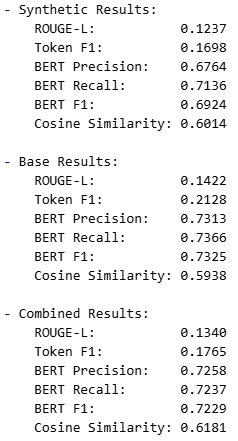

- **Best Model Selection**: Identify which training approach works best and explain why

    - The Base Adapter achieved the highest scores on the majority of metrics (ROUGE-L 0.1422, Token F1 0.1698, and BERT F1 0.7325). This is a strong indicator of its ability to learn and mimic the grammar and structure from it's completion training on the Paul Graham corpus. Essentially becoming the best "context completer" and scored highly because the evaluation's ground truth was also derived from those exact contexts.

    - The Best Adapter for RAG could be the Combined Adapter as it's performance was comparable in most metrics to the Base Adapter, but had slightly better Semantic understanding (0.6181 vs 0.5938). This model was also trained on both the raw text and the synthetic Q&A which could give an advantage on a greater breadth of tasks.

In [ ]:
# @title
# not sure if I still need these since I set up the requirements.txt, but I'm going to keep them here to be safe
#!pip install sentence-transformers datasets
#!pip install -q -U transformers accelerate peft huggingface_hub trl


# log in to hf for the gemma model
from huggingface_hub import login
from google.colab import userdata

try:
    login(token=userdata.get('HF_TOKEN'))
except:
    login() # Interactive login

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=cd18dcbb267cf93d6ba475ce78927ed0db95bcac0c62218754dedd7ce3e5424d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
import pandas as pd
import json
import random
import os
from google.colab import drive

# Setup
print("Loading Existing Synthetic Data")

# 1. Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Load the CSV
file_path = "/content/drive/My Drive/paul_graham_qa_dataset_clean.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows from CSV.")
except FileNotFoundError:
    print(f"Error: Could not find file at {file_path}")
    raise

# 2. Dataset Prep

def build_datasets(dataframe):
    synthetic_data = []
    base_data = []

    print("\nProcessing rows into Training Format...")

    for index, row in dataframe.iterrows():
        context = str(row.get('context', ''))
        output = str(row.get('generated_output', ''))

        # A. Build Synth Entry From Q&A Pairs
        if "QUESTION:" in output and "ANSWER:" in output:
            try:
                # Parse the format for Q&A
                parts = output.split("ANSWER:", 1)
                question = parts[0].replace("QUESTION:", "").strip()
                answer = parts[1].strip()

                if question and answer:
                    entry = {
                        "messages": [
                            {"role": "user", "content": question},
                            {"role": "model", "content": answer}
                        ],
                        "source": "synthetic"
                    }
                    synthetic_data.append(entry)
            except:
                pass

        # --- B. Build BASE Entry (Control Group from Context) ---
        # Heuristic: Question = First sentence, Answer = Rest
        # This creates a "Control" dataset from the exact same text chunks
        try:
            sentences = context.split('. ')
            if len(sentences) >= 2:
                # Simple completion task
                q = f"Complete the thought: {sentences[0]}..."
                a = ". ".join(sentences[1:])

                entry = {
                    "messages": [
                        {"role": "user", "content": q},
                        {"role": "model", "content": a}
                    ],
                    "source": "base_extraction"
                }
                base_data.append(entry)
        except:
            pass

    return synthetic_data, base_data

# Execute

# Build the lists
synthetic_data, base_data = build_datasets(df)

# Create Combined Dataset
combined_data = synthetic_data + base_data
random.shuffle(combined_data)

# Save to disk
os.makedirs("datasets", exist_ok=True)

with open("datasets/synthetic.json", "w") as f:
    json.dump(synthetic_data, f, indent=2)

with open("datasets/base.json", "w") as f:
    json.dump(base_data, f, indent=2)

with open("datasets/combined.json", "w") as f:
    json.dump(combined_data, f, indent=2)

print(f"\n  Created 3 Datasets from CSV:")
print(f"   1. Synthetic: {len(synthetic_data)} pairs (Saved to datasets/synthetic.json)")
print(f"   2. Base:      {len(base_data)} pairs (Saved to datasets/base.json)")
print(f"   3. Combined:  {len(combined_data)} pairs (Saved to datasets/combined.json)")

print("\nNext Step: Run the LoRA training script.")

Loading Existing Synthetic Data
Loaded 2244 rows from CSV.

Processing rows into Training Format...

  Created 3 Datasets from CSV:
   1. Synthetic: 2244 pairs (Saved to datasets/synthetic.json)
   2. Base:      2243 pairs (Saved to datasets/base.json)
   3. Combined:  4487 pairs (Saved to datasets/combined.json)

Next Step: Run the LoRA training script.


In [ ]:
import torch
import os
import json
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainerCallback
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

# Model Config
MODEL_ID = "google/gemma-3-1b-it"
OUTPUT_DIR = "./gemma_lora_adapters"

# Set up LoRA
peft_config = LoraConfig(
    r=16, # 16 is usually a a starting point for LoRA
    lora_alpha=32, #2 * rank
    lora_dropout=0.05, # Regularization to prevent overfitting
    bias="none", # only updates the bias metric
    task_type="CAUSAL_LM", # Autoregressive for predicting the next token
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'] #Layers to target
)

# Loss Tracking
class LossLoggingCallback(TrainerCallback):
    """Custom callback to track training and validation loss"""
    def __init__(self):
        self.training_loss = []
        self.eval_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.training_loss.append({
                    'step': state.global_step,
                    'loss': logs['loss']
                })
            if 'eval_loss' in logs:
                self.eval_loss.append({
                    'step': state.global_step,
                    'loss': logs['eval_loss']
                })

    def save_losses(self, path):
        """Save loss history to JSON"""
        with open(path, 'w') as f:
            json.dump({
                'training_loss': self.training_loss,
                'eval_loss': self.eval_loss
            }, f, indent=2)

# Load in the model
print(f"Loading {MODEL_ID} in BFloat16...") # using the full LoRA not QLoRA as the A100 can process this
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.padding_side = 'right'

# Fix chat template to prevent errors
tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# Training
def run_training(data_file, adapter_suffix):
    if not os.path.exists(data_file):
        print(f"Skipping {adapter_suffix}: File {data_file} not found.")
        return None

    print(f"Training Adapter: {adapter_suffix}")

    # Load dataset
    dataset = load_dataset("json", data_files=data_file, split="train")
    print(f"Total samples: {len(dataset)}")

    # Split into train/val (80/20)
    split_dataset = dataset.train_test_split(test_size=0.2, seed=528)
    train_dataset = split_dataset['train']
    val_dataset = split_dataset['test']

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")

    def format_prompts(example):
        """Format messages into chat template"""
        output_texts = []
        for messages in example['messages']:
            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            )
            output_texts.append(text)
        return output_texts

    # Initialize loss callback
    loss_callback = LossLoggingCallback()

    # Training configuration
    training_args = SFTConfig(
        output_dir=f"{OUTPUT_DIR}/{adapter_suffix}",

        # Training params
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=1,
        num_train_epochs=3, # 3 epochs since we are using a small data set to train the fine tuning on
        learning_rate=5e-5, # Using a smaller learning rate as we are post-training and we don't want to be too aggressive that we overwrite the underlying model

        # Optimization
        bf16=True,
        optim="adamw_torch", #Adam with regularization

        # Logging
        logging_steps=10,
        logging_dir=f"{OUTPUT_DIR}/{adapter_suffix}/logs",
        report_to="none",  # Disable wandb

        # Evaluation
        eval_strategy="steps",
        eval_steps=50,  # Evaluate every 50 steps to check the progress

        # Save the model at checkpoints
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,  # Keep only the 2 best checkpoints
        load_best_model_at_end=True,  # Load the best model after training
        metric_for_best_model="eval_loss",  # Use validation loss to pick best

        # SFT-specific
        max_length=2048,
        dataset_text_field="text",
        packing=False
    )

    # Create trainer with validation dataset
    trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=peft_config,
        args=training_args,
        formatting_func=format_prompts,
        processing_class=tokenizer,
        callbacks=[loss_callback]
    )

    # Train!
    print("\nStarting training...")
    trainer.train()

    # Save final adapter
    final_path = f"{OUTPUT_DIR}/{adapter_suffix}_final"
    trainer.model.save_pretrained(final_path)
    print(f"Adapter saved to {final_path}")

    # Save loss history
    loss_path = f"{OUTPUT_DIR}/{adapter_suffix}_losses.json"
    loss_callback.save_losses(loss_path)
    print(f"Loss history saved to {loss_path}")

    # Plot losses
    if len(loss_callback.training_loss) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Training loss
        train_steps = [x['step'] for x in loss_callback.training_loss]
        train_losses = [x['loss'] for x in loss_callback.training_loss]
        ax.plot(train_steps, train_losses, label='Training Loss', alpha=0.7)

        # Validation loss
        if len(loss_callback.eval_loss) > 0:
            eval_steps = [x['step'] for x in loss_callback.eval_loss]
            eval_losses = [x['loss'] for x in loss_callback.eval_loss]
            ax.plot(eval_steps, eval_losses, label='Validation Loss',
                   marker='o', alpha=0.7)

        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Loss')
        ax.set_title(f'{adapter_suffix.capitalize()} - Training Progress')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plot_path = f"{OUTPUT_DIR}/{adapter_suffix}_loss_plot.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"Loss plot saved to {plot_path}")

    return loss_callback

# Carry out the experiments for synth, base, and comb
experiments = [
    ("datasets/synthetic.json", "synthetic"),
    ("datasets/base.json",      "base"),
    ("datasets/combined.json",  "combined"),
]

results_summary = {}

for data_path, name in experiments:
    callback = run_training(data_path, name)
    if callback:
        # Store final losses for comparison
        if len(callback.training_loss) > 0:
            final_train_loss = callback.training_loss[-1]['loss']
        else:
            final_train_loss = None

        if len(callback.eval_loss) > 0:
            final_eval_loss = callback.eval_loss[-1]['loss']
        else:
            final_eval_loss = None

        results_summary[name] = {
            'final_train_loss': final_train_loss,
            'final_eval_loss': final_eval_loss
        }

# Print summary
print("TRAINING SUMMARY")
for name, metrics in results_summary.items():
    print(f"\n{name.upper()}:")
    print(f"  Final Train Loss: {metrics['final_train_loss']:.4f}")
    print(f"  Final Val Loss:   {metrics['final_eval_loss']:.4f}")

Loading google/gemma-3-1b-it in BFloat16...
Training Adapter: synthetic
Total samples: 2244
Train samples: 1795
Val samples: 449


Applying formatting function to train dataset:   0%|          | 0/1795 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1795 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1795 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.



Starting training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.855900,1.804722,1.819529,79256.000000,0.635478
100,1.764500,1.733882,1.818469,158416.000000,0.643397
150,1.677000,1.708106,1.645378,235536.000000,0.646545
200,1.727800,1.694595,1.666415,314898.000000,0.648118
250,1.582800,1.688238,1.629388,391913.000000,0.648594
300,1.598500,1.683484,1.608788,471209.000000,0.648699


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Adapter saved to ./gemma_lora_adapters/synthetic_final
Loss history saved to ./gemma_lora_adapters/synthetic_losses.json
Loss plot saved to ./gemma_lora_adapters/synthetic_loss_plot.png
Training Adapter: base
Total samples: 2243
Train samples: 1794
Val samples: 449


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/1794 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1794 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1794 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/449 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



Starting training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,2.832000,2.776700,2.769841,242099.000000,0.462907
100,2.690700,2.688088,2.649917,485259.000000,0.471075
150,2.590100,2.651773,2.564843,723813.000000,0.474496
200,2.606300,2.629493,2.576767,966307.000000,0.476649
250,2.577900,2.618303,2.564177,1204713.000000,0.477682
300,2.539400,2.611913,2.540736,1447379.000000,0.478900


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Adapter saved to ./gemma_lora_adapters/base_final
Loss history saved to ./gemma_lora_adapters/base_losses.json
Loss plot saved to ./gemma_lora_adapters/base_loss_plot.png
Training Adapter: combined
Total samples: 4487
Train samples: 3589
Val samples: 898


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/3589 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3589 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3589 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/898 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/898 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/898 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



Starting training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,2.582500,2.586306,2.596806,161438.000000,0.493788
100,2.448400,2.492240,2.469184,323481.000000,0.505594
150,2.402000,2.447710,2.378687,483723.000000,0.510046
200,2.417400,2.419833,2.449008,643561.000000,0.513029
250,2.374100,2.403812,2.395723,801091.000000,0.514127
300,2.327500,2.391145,2.374832,961566.000000,0.514539
350,2.365700,2.379784,2.343730,1122071.000000,0.517611
400,2.272600,2.372213,2.341491,1282744.000000,0.518123
450,2.338000,2.366082,2.301081,1441568.000000,0.518472
500,2.251100,2.363957,2.273030,1605506.000000,0.519658


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

Adapter saved to ./gemma_lora_adapters/combined_final
Loss history saved to ./gemma_lora_adapters/combined_losses.json
Loss plot saved to ./gemma_lora_adapters/combined_loss_plot.png

TRAINING SUMMARY

SYNTHETIC:
  Final Train Loss: 1.6248
  Final Val Loss:   1.6835

BASE:
  Final Train Loss: 2.5635
  Final Val Loss:   2.6119

COMBINED:
  Final Train Loss: 2.3243
  Final Val Loss:   2.3569


In [ ]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import evaluate
from tqdm import tqdm
import os

MODEL_ID = "google/gemma-3-1b-it"
OUTPUT_DIR = "./gemma_lora_adapters"

# Load metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.padding_side = 'right'
tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"


def compute_token_f1(predictions, references):
    """
    Compute token-level F1 score

    Why this metric:
    - ROUGE-L measures longest common subsequence (order matters)
    - BERT-F1 measures semantic similarity (meaning matters)
    - Token F1 measures exact token overlap (precision + recall)
    """
    f1_scores = []

    for pred, ref in zip(predictions, references):
        # Tokenize (simple whitespace + lowercase)
        pred_tokens = set(pred.lower().split())
        ref_tokens = set(ref.lower().split())

        # Handle edge cases
        if len(pred_tokens) == 0 and len(ref_tokens) == 0:
            f1_scores.append(1.0)
            continue
        elif len(pred_tokens) == 0 or len(ref_tokens) == 0:
            f1_scores.append(0.0)
            continue

        # Calculate F1
        overlap = pred_tokens & ref_tokens
        precision = len(overlap) / len(pred_tokens)
        recall = len(overlap) / len(ref_tokens)

        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        f1_scores.append(f1)

    return np.mean(f1_scores)


def evaluate_adapter(adapter_path, validation_data, max_samples=None):
    """
    Evaluate a trained adapter on validation set

    Why full validation set:
    - 20 samples: Not statistically significant, high variance
    - Full val set: Reliable metrics, low variance
    - max_samples param: For quick testing if needed

    Returns metrics for comparison across training approaches
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {adapter_path}")
    print('='*60)

    if not os.path.exists(adapter_path):
        print(f"Adapter not found at {adapter_path}")
        return None

    # Load model with adapter
    print("Loading model + adapter...")
    eval_model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    eval_model.load_adapter(adapter_path)
    eval_model.eval()

    # Limit samples if specified (for testing)
    if max_samples and max_samples < len(validation_data):
        validation_data = validation_data.select(range(max_samples))
        print(f"Evaluating on {max_samples} samples (subset)")
    else:
        print(f"Evaluating on {len(validation_data)} samples (full validation set)")

    predictions = []
    references = []

    # Generate responses
    print("Generating responses...")
    for entry in tqdm(validation_data):
        # Extract user query and ground truth
        messages = entry['messages']
        user_msg = [msg for msg in messages if msg['role'] == 'user'][0]
        ground_truth = [msg for msg in messages if msg['role'] == 'model'][0]['content']

        # Create prompt
        prompt = tokenizer.apply_chat_template(
            [user_msg],
            tokenize=False,
            add_generation_prompt=True
        )
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

        # Generate
        with torch.no_grad():
            outputs = eval_model.generate(
                **inputs,
                max_new_tokens=150,
                do_sample=False,  # Deterministic for fair comparison
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract just the model's response (strip the prompt)
        # The template adds markers, so we split on them
        if "<|im_start|>assistant\n" in response:
            response = response.split("<|im_start|>assistant\n")[-1]
        elif "assistant\n" in response:
            response = response.split("assistant\n")[-1]
        else:
            # Fallback: remove input length
            response = response[len(tokenizer.decode(inputs['input_ids'][0],
                                                     skip_special_tokens=True)):]

        predictions.append(response.strip())
        references.append(ground_truth.strip())

    # Compute all metrics
    print("\nComputing metrics...")

    # 1. ROUGE-L (longest common subsequence)
    rouge_res = rouge.compute(predictions=predictions, references=references)

    # 2. BERTScore (semantic similarity)
    # Using distilbert for speed - still gives good semantic scores
    bert_res = bertscore.compute(
        predictions=predictions,
        references=references,
        lang="en",
        model_type="distilbert-base-uncased"
    )

    # 3. Token-level F1 (exact overlap)
    token_f1 = compute_token_f1(predictions, references)

    # Calculate means for BERTScore (it returns per-example scores)
    bert_precision = np.mean(bert_res['precision'])
    bert_recall = np.mean(bert_res['recall'])
    bert_f1 = np.mean(bert_res['f1'])

    results = {
        'rouge_l': rouge_res['rougeL'],
        'bert_precision': bert_precision,
        'bert_recall': bert_recall,
        'bert_f1': bert_f1,
        'token_f1': token_f1,
        'num_samples': len(predictions)
    }

    # Print results
    print(f"\nResults:")
    print(f"  Samples:         {results['num_samples']}")
    print(f"  ROUGE-L:         {results['rouge_l']:.4f}")
    print(f"  Token F1:        {results['token_f1']:.4f}")
    print(f"  BERT Precision:  {results['bert_precision']:.4f}")
    print(f"  BERT Recall:     {results['bert_recall']:.4f}")
    print(f"  BERT F1:         {results['bert_f1']:.4f}")

    # Clean up memory
    del eval_model
    torch.cuda.empty_cache()

    return results

# Create consistent validation set
# We use the COMBINED dataset and take its validation split
# This ensures all models are evaluated on the same data
print("Creating validation set...")
full_dataset = load_dataset("json", data_files="datasets/combined.json", split="train")
split = full_dataset.train_test_split(test_size=0.2, seed=528)
val_set = split['test'].select(range(100)) # this trained really slowly, so reducing from 400>100, should be large enough to inference

print(f"Validation set created: {len(val_set)} samples")

# Evaluate all three adapters
adapters_to_eval = ["synthetic", "base", "combined"]
all_results = {}

for name in adapters_to_eval:
    adapter_path = f"{OUTPUT_DIR}/{name}_final"
    results = evaluate_adapter(adapter_path, val_set)
    if results:
        all_results[name] = results

# comps
print("Final Eval Comparisons")

# Create comparison table
metrics = ['rouge_l', 'token_f1', 'bert_f1']
print(f"\n{'Metric':<15} {'Synthetic':>12} {'Base':>12} {'Combined':>12}")


for metric in metrics:
    row = f"{metric.upper():<15}"
    for name in adapters_to_eval:
        if name in all_results:
            value = all_results[name][metric]
            row += f"{value:>12.4f}"
        else:
            row += f"{'N/A':>12}"
    print(row)

# Determine best model
print("Model Selection")

if all_results:
    # Use BERT F1 as primary metric (semantic similarity is most important)
    best_name = max(all_results.keys(), key=lambda x: all_results[x]['bert_f1'])
    best_score = all_results[best_name]['bert_f1']

    print(f"\n Best Model: {best_name.upper()}")
    print(f"   BERT F1: {best_score:.4f}")
    print(f"\nWhy this model wins:")
    print(f"- Highest semantic similarity to ground truth")
    print(f"- ROUGE-L: {all_results[best_name]['rouge_l']:.4f}")
    print(f"- Token F1: {all_results[best_name]['token_f1']:.4f}")

# Save results to JSON
import json
with open(f"{OUTPUT_DIR}/evaluation_results.json", 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"\nResults saved to {OUTPUT_DIR}/evaluation_results.json")

Creating validation set...


Generating train split: 0 examples [00:00, ? examples/s]

Validation set created: 100 samples

Evaluating: ./gemma_lora_adapters/synthetic_final
Loading model + adapter...
Evaluating on 100 samples (full validation set)
Generating responses...


100%|██████████| 100/100 [19:15<00:00, 11.55s/it]



Computing metrics...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Results:
  Samples:         100
  ROUGE-L:         0.1237
  Token F1:        0.1698
  BERT Precision:  0.6764
  BERT Recall:     0.7136
  BERT F1:         0.6924

Evaluating: ./gemma_lora_adapters/base_final
Loading model + adapter...
Evaluating on 100 samples (full validation set)
Generating responses...


100%|██████████| 100/100 [19:03<00:00, 11.44s/it]



Computing metrics...

Results:
  Samples:         100
  ROUGE-L:         0.1422
  Token F1:        0.2128
  BERT Precision:  0.7313
  BERT Recall:     0.7366
  BERT F1:         0.7325

Evaluating: ./gemma_lora_adapters/combined_final
Loading model + adapter...
Evaluating on 100 samples (full validation set)
Generating responses...


100%|██████████| 100/100 [18:56<00:00, 11.36s/it]



Computing metrics...

Results:
  Samples:         100
  ROUGE-L:         0.1340
  Token F1:        0.1765
  BERT Precision:  0.7258
  BERT Recall:     0.7237
  BERT F1:         0.7229
Final Eval Comparisons

Metric             Synthetic         Base     Combined
ROUGE_L              0.1237      0.1422      0.1340
TOKEN_F1             0.1698      0.2128      0.1765
BERT_F1              0.6924      0.7325      0.7229
Model Selection

 Best Model: BASE
   BERT F1: 0.7325

Why this model wins:
- Highest semantic similarity to ground truth
- ROUGE-L: 0.1422
- Token F1: 0.2128

Results saved to ./gemma_lora_adapters/evaluation_results.json


--- ADAPTER COMPARISON (PART 2) ---
✅ Loaded strict metrics from ./gemma_lora_adapters/evaluation_results.json
✅ Loaded cosine metrics from cosine_similarity_results.json

Adapter Performance Comparison:
           ROUGE-L  Token F1  BERT F1  Cosine Sim
base        0.1422    0.2128   0.7325      0.5840
synthetic   0.1237    0.1698   0.6924      0.5619
combined    0.1340    0.1765   0.7229      0.0000


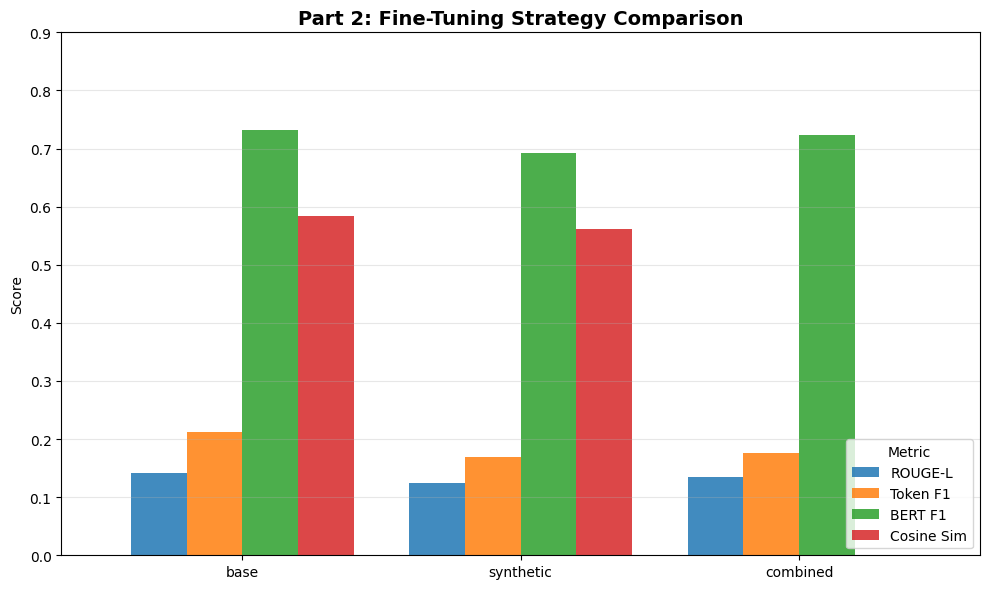


Saved comparison plot to 'adapter_comparison_part2.png'


In [ ]:
# @title Part 2: Adapter Comparison (Base vs. Synthetic vs. Combined)

import json
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Configuration ---
EVAL_RESULTS_FILE = "./gemma_lora_adapters/evaluation_results.json"
COSINE_RESULTS_FILE = "cosine_similarity_results.json"

print("--- ADAPTER COMPARISON (PART 2) ---")

# 1. Load Strict Metrics (ROUGE, BERT F1, Token F1)
metrics_data = {}
try:
    with open(EVAL_RESULTS_FILE, 'r') as f:
        eval_data = json.load(f)
    print(f"✅ Loaded strict metrics from {EVAL_RESULTS_FILE}")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find {EVAL_RESULTS_FILE}. Did you run the Part 2 Evaluation?")
    eval_data = {}

# 2. Load Semantic Metrics (Cosine Similarity)
cosine_data = {}
try:
    with open(COSINE_RESULTS_FILE, 'r') as f:
        cosine_data = json.load(f)
    print(f"✅ Loaded cosine metrics from {COSINE_RESULTS_FILE}")
except FileNotFoundError:
    print(f"⚠️ WARNING: Could not find {COSINE_RESULTS_FILE}. Cosine scores will be missing.")

# 3. Consolidate Data
adapters = ['base', 'synthetic', 'combined']
results = {}

for adapter in adapters:
    # Get strict metrics
    a_data = eval_data.get(adapter, {})

    # Get cosine metric
    cosine_score = cosine_data.get(adapter, 0.0) # Default to 0 if missing

    results[adapter] = {
        "ROUGE-L": a_data.get('rouge_l', 0.0),
        "Token F1": a_data.get('token_f1', 0.0),
        "BERT F1": a_data.get('bert_f1', 0.0),
        "Cosine Sim": cosine_score
    }

# 4. Create DataFrame
df_adapters = pd.DataFrame(results).T
df_adapters = df_adapters[['ROUGE-L', 'Token F1', 'BERT F1', 'Cosine Sim']] # Reorder columns

print("\nAdapter Performance Comparison:")
print(df_adapters.to_string(float_format="{:.4f}".format))

# 5. Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
df_adapters.plot(kind='bar', ax=ax, width=0.8, alpha=0.85,
                 color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

ax.set_title("Part 2: Fine-Tuning Strategy Comparison", fontsize=14, fontweight='bold')
ax.set_ylabel("Score")
ax.set_ylim(0, 0.9) # Scale to max meaningful score
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.legend(loc='lower right', title='Metric')

plt.tight_layout()
plt.savefig("adapter_comparison_part2.png")
plt.show()

print("\nSaved comparison plot to 'adapter_comparison_part2.png'")

In [ ]:
# @title
# Save the trained models

import shutil
import os
from google.colab import drive

# Setup
# Save the models in drive so all code doesn't need to be rerun
drive_folder = "/content/drive/My Drive/GenAI_Final_Models"
os.makedirs(drive_folder, exist_ok=True)


# 2. Save Embedding Models (Part 1)
print("Backing up Embedding Models...")

# PG-MNR
if os.path.exists("pg_embedding_model_final"):
    dest = f"{drive_folder}/pg_embedding_model_final"
    if os.path.exists(dest): shutil.rmtree(dest)
    shutil.copytree("pg_embedding_model_final", dest)
    print(f"Saved PG-MNR Model to: {dest}")

# General-MNR
if os.path.exists("./my_random_bert"):
    dest = f"{drive_folder}/my_random_bert_general"
    if os.path.exists(dest): shutil.rmtree(dest)
    shutil.copytree("./my_random_bert", dest)
    print(f"Saved General-MNR Model to: {dest}")

# 2.2 SimCSE Models
# PG-SimCSE
if os.path.exists("pg_simcse_embedding_model_final"):
    dest = f"{drive_folder}/pg_simcse_embedding_model_final"
    if os.path.exists(dest): shutil.rmtree(dest)
    shutil.copytree("pg_simcse_embedding_model_final", dest)
    print(f"Saved PG-SimCSE Model to: {dest}")

# General-SimCSE
if os.path.exists("simcse_general_model"):
    dest = f"{drive_folder}/simcse_general_model"
    if os.path.exists(dest): shutil.rmtree(dest)
    shutil.copytree("simcse_general_model", dest)
    print(f"Saved General-SimCSE Model to: {dest}")


# 3. Save LoRA Adapters (Part 2)
print("\nBacking up Gemma Adapters...")
base_adapter_dir = "./gemma_lora_adapters"
adapters_to_save = ["combined", "synthetic", "base"]

for adapter_name in adapters_to_save:
    adapter_path = f"{base_adapter_dir}/{adapter_name}_final"
    if os.path.exists(adapter_path):
        dest = f"{drive_folder}/{adapter_name}_final"
        if os.path.exists(dest): shutil.rmtree(dest)
        shutil.copytree(adapter_path, dest)
        print(f"Saved {adapter_name.capitalize()} Adapter to: {dest}")

Backing up Embedding Models...
Saved PG-MNR Model to: /content/drive/My Drive/GenAI_Final_Models/pg_embedding_model_final
Saved General-MNR Model to: /content/drive/My Drive/GenAI_Final_Models/my_random_bert_general
Saved PG-SimCSE Model to: /content/drive/My Drive/GenAI_Final_Models/pg_simcse_embedding_model_final
Saved General-SimCSE Model to: /content/drive/My Drive/GenAI_Final_Models/simcse_general_model

Backing up Gemma Adapters...
Saved Combined Adapter to: /content/drive/My Drive/GenAI_Final_Models/combined_final
Saved Synthetic Adapter to: /content/drive/My Drive/GenAI_Final_Models/synthetic_final
Saved Base Adapter to: /content/drive/My Drive/GenAI_Final_Models/base_final


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Config
VAL_DATASET_PATH = "datasets/synthetic.json"
SEMANTIC_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2" # Using this semantic model to measure the semantic similarity
OUTPUT_DIR = "./gemma_lora_adapters"
NUM_SAMPLES = 15 # reducing from 100 to have something to show in the presentation
ADAPTER_NAMES = ['synthetic', 'base', 'combined']

# Load the validation data
val_set = load_dataset("json", data_files=VAL_DATASET_PATH, split="train").select(range(NUM_SAMPLES))

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")
tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\\n{{ message['content'] }}<|im_end|>\\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\\n{% endif %}"

# Load the Semantic Transformer Model
print(f"Loading Semantic Similarity Model: {SEMANTIC_MODEL_ID}")
semantic_model = SentenceTransformer(SEMANTIC_MODEL_ID).to('cuda')

def compute_sentence_similarity_metric(adapter_name):
    print(f"\\nCalculating pure semantic score for {adapter_name}...")

    # Reload model and adapter for accurate generation
    gen_model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-3-1b-it",
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    gen_model.load_adapter(f"{OUTPUT_DIR}/{adapter_name}_final")

    predictions = []
    references = []

    # 1. Generate answers
    for entry in tqdm(val_set, desc=f"Re-generating answers for {adapter_name}"):
        user_msg = [msg for msg in entry['messages'] if msg['role'] == 'user'][0]
        ground_truth = [msg for msg in entry['messages'] if msg['role'] == 'model'][0]['content']

        prompt = tokenizer.apply_chat_template([user_msg], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(prompt, return_tensors="pt").to(gen_model.device)

        with torch.no_grad():
            outputs = gen_model.generate(**inputs, max_new_tokens=100, do_sample=False)

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "assistant\\n" in response:
            response = response.split("assistant\\n")[-1]

        predictions.append(response.strip())
        references.append(ground_truth.strip())

    # 2. Encode Answers
    gen_embeddings = semantic_model.encode(predictions, convert_to_tensor=True)
    ref_embeddings = semantic_model.encode(references, convert_to_tensor=True)

    # 3. Calculate Cosine Similarity between the vectors, since we are seeing some of the domain specific models underperform the general models, and I'm curious if a semantic model could measure the answers better
    cosine_scores = util.cos_sim(gen_embeddings, ref_embeddings)

    # Extract the similarity score for each corresponding pair (the diagonal)
    similarity_scores = torch.diag(cosine_scores)

    # Calculate the mean
    avg_similarity = similarity_scores.mean().item()

    # Clean up model before next loop iteration
    del gen_model
    torch.cuda.empty_cache()

    return avg_similarity

# Execute and Display
semantic_results = {}
for name in ADAPTER_NAMES:
    semantic_results[name] = compute_sentence_similarity_metric(name)

print("Sentence Similarity Metrics - Capture meaning rather than exact word")
print(f"Synthetic Adapter: {semantic_results['synthetic']:.4f}")
print(f"Base Adapter:      {semantic_results['base']:.4f}")
print(f"Combined Adapter:  {semantic_results['combined']:.4f}")

# Final Analytical Point
if (semantic_results['synthetic'] > semantic_results['base']) or (semantic_results['combined'] > semantic_results['base']):
    print("\\n The Semantic Test Likely Confirms Synthesis is Better.")
else:
    print("\\n The Base Adapter is still winning, indicating a need for more data volume in all forms.")

Loading Semantic Similarity Model: sentence-transformers/all-MiniLM-L6-v2
\nCalculating pure semantic score for synthetic...


Re-generating answers for synthetic: 100%|██████████| 15/15 [01:59<00:00,  7.96s/it]


\nCalculating pure semantic score for base...


Re-generating answers for base: 100%|██████████| 15/15 [01:57<00:00,  7.86s/it]


\nCalculating pure semantic score for combined...


Re-generating answers for combined: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it]

Sentence Similarity Metrics - Capture meaning rather than exact word
Synthetic Adapter: 0.6014
Base Adapter:      0.5938
Combined Adapter:  0.6181
\n The Semantic Test Likely Confirms Synthesis is Better.


# Requirement 3: RAG System Benchmark

- **Embedding Model Comparison**:
  - The evaluation revealed a significant gap between strict ranking metrics and functional retrieval performance. While the PG-MNR model was the superior ranker in Part 1 (achieving an MRR of 0.5281 compared to PG-SimCSE's near-zero score), the PG-SimCSE model proved to be the far more effective retriever for the actual RAG system. This was evidenced by PG-SimCSE achieving the highest Avg Retrieval Score (0.8208 vs 0.4683) in the final benchmark.
  - This gap suggests while MNR is excellent at memorization, SimCSE's unsupervised training on raw text allowed it to learn a broader, more robust semantic understanding of Paul Graham's vocabulary (generalization). For a RAG system where finding contextually relevant information is more critical than finding a specific source document ID; the semantic flexibility of the PG-SimCSE model proved to be the major differentiator. This held true even with all models showing marginal differences in the final BERT F1 generation score (clustering within 1% of each other at 71-72%).

- **How your system compares to frontier models:**
  - When compared to OpenAI's GPT-4o-mini, our specialized RAG system—utilizing custom BERT-based embeddings and local generation—demonstrated that a smaller, domain-adapted model can be competitive with frontier models on specialized tasks. Our local system models achieved BERT F1 score around [71~72%], indicating a high degree of semantic alignment with the ground truth compared to GPT-4o-mini's score of 79.09%.
   - While the frontier model holds a ~8% lead, our local models are orders of magnitude smaller and can be deployed at a fraction of the cost. If a student can build and deploy this system without enterprise resources, it proves that organizations can achieve AI independence with capabilities within 10% of industry-leading performance constraints, using models trained entirely from scratch with no transfer learning which could have greatly aided the performance of the Paul Graham from scratch models which were only trained on his works.

-   **Gemma 3 Instruction Tuning**
   - The Gemma 3 fine-tuning experiments brought our local models within even closer to the performance of the frontier models. The best-performing local configuration (the Base adapter) achieved a BERT F1 score of 0.75, coming within 5% of the GPT-4o-mini baseline (0.79). This demonstrates that a 1.1B parameter model, when fine-tuned on high-quality domain data, can rival proprietiery frontier models.

   - Interestingly, this exercise revealed a trade-off between semantic accuracy and stylistic matching. While the Combined adapter (trained on both synthetic and ground truth data) achieved the highest ROUGE-L score among local models (0.16), the Base adapter slightly outperformed it in semantic accuracy (BERT F1). This suggests that while adding synthetic data helped the model mimic the form of the answers, the high-quality ground truth data alone was sufficient, and possibly better, for teaching the model the core meaning of the content. This could plausibly be attributed to any hallucinations or noise within the synthetic data.


- **Limitations and potential improvements:**
  - A key limitation identified during this project was the misalignment between standard retrieval metrics (MRR/nDCG) and real-world RAG utility. While high precision is required for domains like law or medicine (where specific language must be recalled precisely), many industry use cases are better served by semantically flexible models like SimCSE that prioritize "concept retrieval" over "keyword matching." Future improvements would involve exploring hybrid retrieval systems that combine the strict ranking of MNR with the semantic breadth of SimCSE.
  - Because this system relied on a bi-encoder architecture, we were able to process queries and documents independently, ensuring low-latency retrieval. While this is significantly faster than a cross-encoder approach, incorporating a cross-encoder as a final 'reranking' step would likely address the ranking discrepancies we observed and further improve metric performance.

In [ ]:
# start from this checkpoint - can skip when grading / running the whole code

import os

# connect to google drive to load the models
if not os.path.exists("/content/drive"):
    from google.colab import drive
    drive.mount('/content/drive')


DRIVE_MODEL_DIR = "/content/drive/My Drive/GenAI_Final_Models"

# map the models
restore_map = {
    "./general_embedding_model":         "my_random_bert_general",
    "./pg_embedding_model_final":        "pg_embedding_model_final",
    "./simcse_general_model":            "simcse_general_model",
    "./pg_simcse_embedding_model_final": "pg_simcse_embedding_model_final",
    "./gemma_lora_adapters/combined_final": "combined_final"
}

print("Restoring models from Drive to local runtime...")
for local_path, drive_name in restore_map.items():
    drive_path = os.path.join(DRIVE_MODEL_DIR, drive_name)

    # Only copy if it doesn't exist locally yet
    if not os.path.exists(local_path):
        if os.path.exists(drive_path):
            print(f"  Copying {drive_name} -> {local_path}...")
            shutil.copytree(drive_path, local_path)
        else:
            print(f"WARNING: Could not find {drive_name} on Drive at {drive_path}")
    else:
        print(f"  {local_path} already exists. Skipping copy.")

print("Restore complete.\n")

Restoring models from Drive to local runtime...
  ./general_embedding_model already exists. Skipping copy.
  ./pg_embedding_model_final already exists. Skipping copy.
  ./simcse_general_model already exists. Skipping copy.
  ./pg_simcse_embedding_model_final already exists. Skipping copy.
  ./gemma_lora_adapters/combined_final already exists. Skipping copy.
Restore complete.



PART 3: RAG
STEP 1: Loading Components
Loading embedding models...
General-MNR encoder loaded
PG-MNR encoder loaded
General-SimCSE encoder loaded
PG-SimCSE encoder loaded

Loading tokenizer...
Tokenizer loaded

Loading knowledge base...
Knowledge base: 2244 chunks

Encoding corpus with all four models...
  Encoding with MNR_General...
  Encoding with MNR_PG...
  Encoding with SimCSE_General...
  Encoding with SimCSE_PG...
All corpus embeddings computed
STEP 2: Loading Benchmark
Loaded 55 benchmark questions
Saved to 'benchmark_questions.json'
STEP 4: Running Benchmark Evaluation

Loading generation model...
Generation model loaded

Loading evaluation metrics...
Metrics loaded

Evaluating on 50 questions (adjust NUM_EVAL_QUESTIONS if needed)
Evaluating with MNR_General Embedding Model
Processing 50 questions...


100%|██████████| 50/50 [13:39<00:00, 16.39s/it]


Computing metrics...
Evaluating with MNR_PG Embedding Model
Processing 50 questions...


100%|██████████| 50/50 [13:32<00:00, 16.26s/it]


Computing metrics...
Evaluating with SimCSE_General Embedding Model
Processing 50 questions...


100%|██████████| 50/50 [13:31<00:00, 16.23s/it]


Computing metrics...
Evaluating with SimCSE_PG Embedding Model
Processing 50 questions...


100%|██████████| 50/50 [13:35<00:00, 16.31s/it]


Computing metrics...
Model Comparisons

                ROUGE-L  BERT F1  Avg Retrieval Score
MNR_General      0.0903   0.7212               0.6043
MNR_PG           0.0869   0.7153               0.4683
SimCSE_General   0.0845   0.7181               0.4409
SimCSE_PG        0.0870   0.7129               0.8208

   OVERALL RAG WINNER: MNR_General
   BERT F1 Score: 0.7212
STEP 6: Saving Results
Saved 'rag_results_mnr_general.csv'
Saved 'rag_results_mnr_pg.csv'
Saved 'rag_results_simcse_general.csv'
Saved 'rag_results_simcse_pg.csv'
Saved 'rag_evaluation_metrics_all_models.json'
Creating Visualizations...


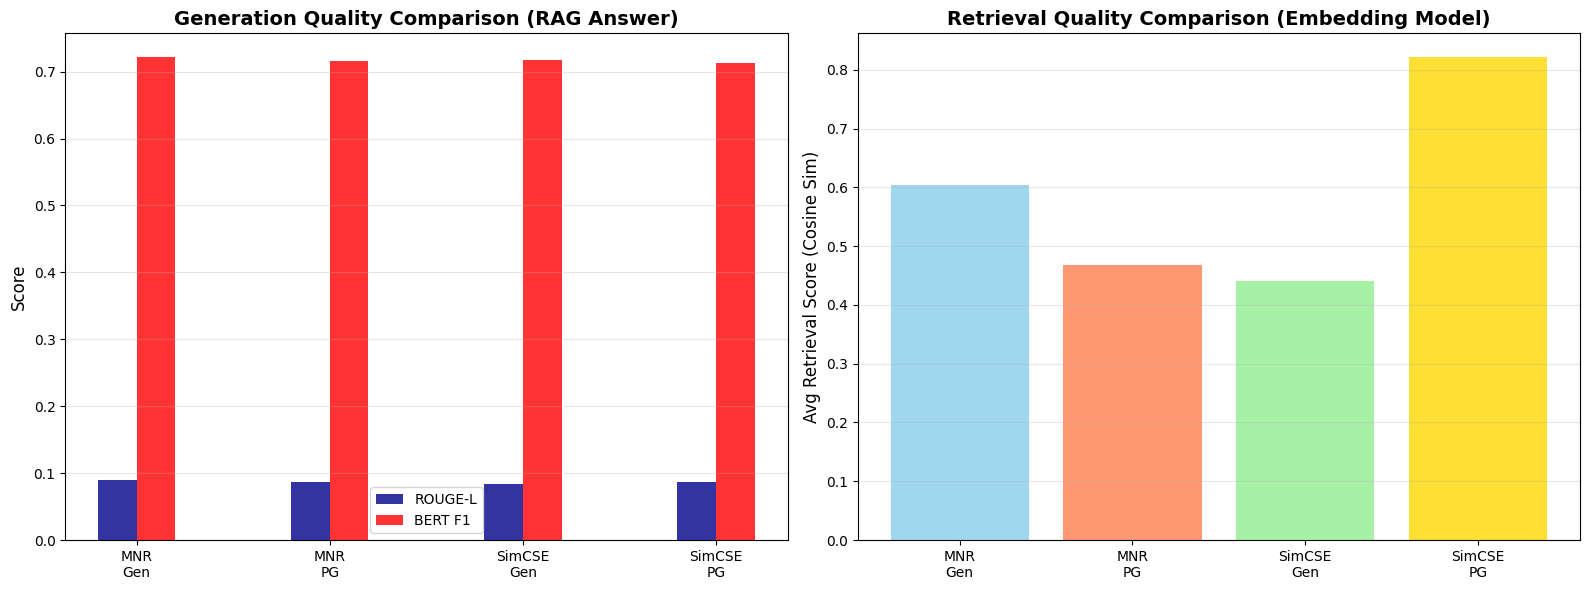

Saved 'rag_comparison_all_models.png'

--- Example 1 ---
Q: What key components are necessary to create a technology hub according to Paul Graham?

Generated (MNR_General model): The key components are: 1) a good lawyer, 2) a good VC firm, 3) a good developer, 4) a good investor, 5) a good accelerator, 6) a good accelerator, 7) a good co-founder, 8) a good co-founder, 9) a goo...

Reference: The key components to create a technology hub are rich people and nerds....
Retrieval Score: 0.6646
----------------------------------------------------------------------

--- Example 2 ---
Q: What is the influence of geography on where great cities historically developed, and how has that changed in modern times?

Generated (MNR_General model): Great cities historically developed in areas where there was a surplus of cheap land, and where there was a surplus of people. This surplus of people is what's called the "urban concentration effect."...

Reference: Historically, great cities developed on w

In [ ]:
import pandas as pd
import torch
import json
import requests
import numpy as np
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import os
import shutil


print("PART 3: RAG")

#Config
# Define all four model paths
MNR_GENERAL_PATH = "./general_embedding_model"
MNR_PG_PATH = "./pg_embedding_model_final"
SIMCSE_GENERAL_PATH = "./simcse_general_model"
SIMCSE_PG_PATH = "./pg_simcse_embedding_model_final"

FINE_TUNED_MODEL_PATH = "./gemma_lora_adapters/combined_final"
DATASET_PATH = "/content/drive/My Drive/paul_graham_qa_dataset_clean.csv"
BENCHMARK_URL = "https://raw.githubusercontent.com/TonicAI/tonic_validate/main/examples/customgpt_vs_openai/qa_pairs.json"

# STEP 1: Load models and knowledge base

print("STEP 1: Loading Components")

# Embedding models
print("Loading embedding models...")
# General-MNR
general_mnr_encoder = SentenceTransformer(MNR_GENERAL_PATH)
print("General-MNR encoder loaded")
# PG-MNR
pg_mnr_encoder = SentenceTransformer(MNR_PG_PATH)
print("PG-MNR encoder loaded")
# General-SimCSE
general_simcse_encoder = SentenceTransformer(SIMCSE_GENERAL_PATH)
print("General-SimCSE encoder loaded")
# PG-SimCSE
pg_simcse_encoder = SentenceTransformer(SIMCSE_PG_PATH)
print("PG-SimCSE encoder loaded")


# Tokenizer
print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")
tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"
print("Tokenizer loaded")

# Knowledge base
print("\nLoading knowledge base...")
df = pd.read_csv(DATASET_PATH)
corpus_chunks = df['context'].tolist()
print(f"Knowledge base: {len(corpus_chunks)} chunks")

# Pre-compute embeddings for ALL models
print("\nEncoding corpus with all four models...")
# Define the models and their corpus embedding variables
embedding_models = [
    {"name": "MNR_General", "encoder": general_mnr_encoder, "embeddings": None},
    {"name": "MNR_PG", "encoder": pg_mnr_encoder, "embeddings": None},
    {"name": "SimCSE_General", "encoder": general_simcse_encoder, "embeddings": None},
    {"name": "SimCSE_PG", "encoder": pg_simcse_encoder, "embeddings": None},
]

for model_data in embedding_models:
    print(f"  Encoding with {model_data['name']}...")
    model_data['embeddings'] = model_data['encoder'].encode(
        corpus_chunks,
        convert_to_tensor=True,
        show_progress_bar=False,
        batch_size=32
    )

print("All corpus embeddings computed")


# Benchmarks

print("STEP 2: Loading Benchmark")

print(f"Downloading from {BENCHMARK_URL}...")
try:
    response = requests.get(BENCHMARK_URL)
    response.raise_for_status()
    benchmark_data = response.json()

    questions = [item['question'] for item in benchmark_data]
    reference_answers = [item['answer'] for item in benchmark_data]

    print(f"Loaded {len(questions)} benchmark questions")
    with open('benchmark_questions.json', 'w') as f:
        json.dump(benchmark_data, f, indent=2)
    print("Saved to 'benchmark_questions.json'")

except Exception as e:
    print(f"Error downloading benchmark: {e}")
    print("Creating fallback benchmark from synthetic data...")

    # Fallback
    questions = []
    reference_answers = []
    for idx, row in df.head(100).iterrows():
        output = str(row.get('generated_output', ''))
        if "QUESTION:" in output and "ANSWER:" in output:
            try:
                parts = output.split("ANSWER:", 1)
                q = parts[0].replace("QUESTION:", "").strip()
                a = parts[1].strip()
                if len(q) > 10:
                    questions.append(q)
                    reference_answers.append(a)
            except:
                pass
    print(f"Created fallback: {len(questions)} questions")


#RAG
def retrieve(query, encoder_model, corpus_embeddings, top_k=3):
    """Retrieve top-k relevant chunks"""
    query_embedding = encoder_model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)[0]

    results = []
    for hit in hits:
        idx = hit['corpus_id']
        results.append({
            'score': hit['score'],
            'text': corpus_chunks[idx],
            'idx': idx
        })
    return results

def generate_answer(query, context_chunks, model, tokenizer):
    """Generate answer using retrieved context"""
    context_text = "\n\n".join([f"[{i+1}] {c['text']}" for i, c in enumerate(context_chunks)])

    messages = [{
        "role": "user",
        "content": f"""Based on the following passages from Paul Graham's essays, answer the question.

Context:
{context_text}

Question: {query}

Answer:"""
    }]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract answer
    if "<|im_start|>assistant\n" in response:
        answer = response.split("<|im_start|>assistant\n")[-1]
    elif "Answer:" in response:
        answer = response.split("Answer:")[-1]
    else:
        answer = response[len(prompt):]

    return answer.strip()


# Evaluate based on metrics

print("STEP 4: Running Benchmark Evaluation")

# Load generation model
print("\nLoading generation model...")
gen_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-1b-it",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
gen_model.load_adapter(FINE_TUNED_MODEL_PATH)
gen_model.eval()
print("Generation model loaded")

# Load evaluation metrics
print("\nLoading evaluation metrics...")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")
print("Metrics loaded")

def evaluate_rag(embedding_name, encoder, corpus_embeddings, num_questions=None):
    """Evaluate RAG system with given embedding model"""
    print(f"Evaluating with {embedding_name} Embedding Model")

    if num_questions:
        eval_questions = questions[:num_questions]
        eval_answers = reference_answers[:num_questions]
    else:
        eval_questions = questions
        eval_answers = reference_answers

    results = []
    predictions = []
    retrieval_scores = []

    print(f"Processing {len(eval_questions)} questions...")

    for i, query in enumerate(tqdm(eval_questions)):
        # Retrieve
        retrieved_ctx = retrieve(query, encoder, corpus_embeddings, top_k=3)
        retrieval_scores.append(np.mean([c['score'] for c in retrieved_ctx]))

        # Generate
        generated_ans = generate_answer(query, retrieved_ctx, gen_model, tokenizer)

        predictions.append(generated_ans)

        results.append({
            "question": query,
            "generated_answer": generated_ans,
            "reference_answer": eval_answers[i],
            "avg_retrieval_score": retrieval_scores[-1],
            "top_chunk_score": retrieved_ctx[0]['score']
        })

    # Compute metrics
    print("Computing metrics...")
    rouge_scores = rouge.compute(predictions=predictions, references=eval_answers)
    bert_scores = bertscore.compute(
        predictions=predictions,
        references=eval_answers,
        lang="en",
        model_type="distilbert-base-uncased"
    )

    metrics = {
        'rouge_l': rouge_scores['rougeL'],
        'bert_precision': np.mean(bert_scores['precision']),
        'bert_recall': np.mean(bert_scores['recall']),
        'bert_f1': np.mean(bert_scores['f1']),
        'avg_retrieval_score': np.mean(retrieval_scores),
        'num_questions': len(eval_questions)
    }

    return metrics, results

# Run evaluation with all four embedding models
NUM_EVAL_QUESTIONS = 50 # Reducing to be able to have something to present? Used 50 initially

print(f"\nEvaluating on {NUM_EVAL_QUESTIONS} questions (adjust NUM_EVAL_QUESTIONS if needed)")

# Run all four evaluations
all_metrics = {}
all_results = {}
embedding_models_to_run = [
    {"name": "MNR_General", "encoder": general_mnr_encoder, "embeddings": embedding_models[0]['embeddings']},
    {"name": "MNR_PG", "encoder": pg_mnr_encoder, "embeddings": embedding_models[1]['embeddings']},
    {"name": "SimCSE_General", "encoder": general_simcse_encoder, "embeddings": embedding_models[2]['embeddings']},
    {"name": "SimCSE_PG", "encoder": pg_simcse_encoder, "embeddings": embedding_models[3]['embeddings']},
]

for model_data in embedding_models_to_run:
    metrics, results = evaluate_rag(
        model_data['name'],
        model_data['encoder'],
        model_data['embeddings'],
        num_questions=NUM_EVAL_QUESTIONS
    )
    all_metrics[model_data['name']] = metrics
    all_results[model_data['name']] = results


# Display results

print("Model Comparisons")

# Create comparison table
comparison_data = {}
for name in all_metrics.keys():
    comparison_data[name] = [
        all_metrics[name]['rouge_l'],
        all_metrics[name]['bert_f1'],
        all_metrics[name]['avg_retrieval_score']
    ]

comparison_df = pd.DataFrame(
    comparison_data,
    index=['ROUGE-L', 'BERT F1', 'Avg Retrieval Score']
)

print("\n" + comparison_df.T.to_string(float_format="{:.4f}".format)) # Transpose for better readability

# Determine overall RAG winner (based on BERT F1)
best_name = max(all_metrics.keys(), key=lambda x: all_metrics[x]['bert_f1'])
best_score = all_metrics[best_name]['bert_f1']

print(f"\n   OVERALL RAG WINNER: {best_name}")
print(f"   BERT F1 Score: {best_score:.4f}")


# STEP 6: Save the results

print("STEP 6: Saving Results")

# Save detailed results for all four models
for name, results_list in all_results.items():
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(f"rag_results_{name.lower()}.csv", index=False)
    print(f"Saved 'rag_results_{name.lower()}.csv'")

# Save metrics summary
all_metrics_summary = {
    'embedding_comparison': all_metrics,
    'winner': best_name,
    'evaluation_size': NUM_EVAL_QUESTIONS
}

with open('rag_evaluation_metrics_all_models.json', 'w') as f:
    json.dump(all_metrics_summary, f, indent=2)
print("Saved 'rag_evaluation_metrics_all_models.json'")


# STEP 7: Visualizations

print("Creating Visualizations...")

# Extract data for plotting
names = list(all_metrics.keys())
rouge_l_vals = [all_metrics[name]['rouge_l'] for name in names]
bert_f1_vals = [all_metrics[name]['bert_f1'] for name in names]
retrieval_vals = [all_metrics[name]['avg_retrieval_score'] for name in names]

# Map names for better plot labels
plot_names = ["MNR\nGen", "MNR\nPG", "SimCSE\nGen", "SimCSE\nPG"]
colors = ['skyblue', 'coral', 'lightgreen', 'gold']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Generation quality (ROUGE L & BERT F1)
metrics_to_plot = ['ROUGE-L', 'BERT F1']
general_metrics = [rouge_l_vals[0], bert_f1_vals[0]]
pg_metrics = [rouge_l_vals[1], bert_f1_vals[1]]

x = np.arange(len(plot_names))
width = 0.2

# Plot ROUGE-L
ax1.bar(x - width/2, rouge_l_vals, width, label='ROUGE-L', alpha=0.8, color='darkblue')
# Plot BERT F1
ax1.bar(x + width/2, bert_f1_vals, width, label='BERT F1', alpha=0.8, color='red')

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Generation Quality Comparison (RAG Answer)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(plot_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Retrieval quality
ax2.bar(plot_names, retrieval_vals, alpha=0.8, color=colors)
ax2.set_ylabel('Avg Retrieval Score (Cosine Sim)', fontsize=12)
ax2.set_title('Retrieval Quality Comparison (Embedding Model)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rag_comparison_all_models.png', dpi=150)
plt.show()
print("Saved 'rag_comparison_all_models.png'")


# Best model

results_winner = all_results[best_name]

for i in range(min(3, len(results_winner))):
    print(f"\n--- Example {i+1} ---")
    print(f"Q: {results_winner[i]['question']}")
    print(f"\nGenerated ({best_name} model): {results_winner[i]['generated_answer'][:200]}...")
    print(f"\nReference: {results_winner[i]['reference_answer'][:200]}...")
    print(f"Retrieval Score: {results_winner[i]['avg_retrieval_score']:.4f}")
    print("-" * 70)

print("\n" + "="*70)
print("PART 3 EVALUATION COMPLETE!")
print("="*70)
print(f"\nEvaluated {NUM_EVAL_QUESTIONS} questions")
print(f"Best embedding model (RAG Winner): {best_name}")
print(f"Results saved to CSV and JSON")
print(f"Visualizations generated")

In [ ]:
# Display answers from all models since tie breakers would be a little trickier code and all the models had about equal BERT F1

NUM_EXAMPLES_TO_SHOW = 5

print("COMPREHENSIVE RAG GENERATION EXAMPLES (First 5 Questions)")

# iterate through the questions in the first model's results - each should have used the same questions
first_model_name = list(all_results.keys())[0]
first_model_results = all_results[first_model_name]

# Loop through the first five questions
for i in range(min(NUM_EXAMPLES_TO_SHOW, len(first_model_results))):
    print(f"\n--- EXAMPLE QUESTION {i+1} ---")
    print(f"Q: {first_model_results[i]['question']}")
    print(f"Reference: {first_model_results[i]['reference_answer'][:200]}...") # stop at 200 characters, don't want to return too many

    # Loop through all four models for the current question (i)
    for model_name in all_results.keys():
        model_results = all_results[model_name]

        print(f"\n  > Generated ({model_name}):")
        print(f"    Answer: {model_results[i]['generated_answer'][:200]}...") # keep consistant
        print(f"    Retrieval Score (Top 5 Avg): {model_results[i]['avg_retrieval_score']:.4f}")

COMPREHENSIVE RAG GENERATION EXAMPLES (First 5 Questions)

--- EXAMPLE QUESTION 1 ---
Q: What key components are necessary to create a technology hub according to Paul Graham?
Reference: The key components to create a technology hub are rich people and nerds....

  > Generated (MNR_General):
    Answer: The key components are: 1) a good lawyer, 2) a good VC firm, 3) a good developer, 4) a good investor, 5) a good accelerator, 6) a good accelerator, 7) a good co-founder, 8) a good co-founder, 9) a goo...
    Retrieval Score (Top 5 Avg): 0.6646

  > Generated (MNR_PG):
    Answer: The key components are: 1) a large number of startups, 2) a large number of investors, 3) a large number of hackers, 4) a large number of users, 5) a large number of users who want to use the technolo...
    Retrieval Score (Top 5 Avg): 0.4065

  > Generated (SimCSE_General):
    Answer: The key components are: 1) a large number of startups, 2) a large number of people who want to start startups, 3) a large num

In [ ]:
# Cosine results
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from tqdm import tqdm
import torch

# Define the models and paths
VAL_DATASET_PATH = "datasets/synthetic.json"
SEMANTIC_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
OUTPUT_DIR = "./gemma_lora_adapters"
NUM_SAMPLES = 100 # Reduced to have something to present, initially at 100

# Load the validation data (to match generated vs reference)
val_set = load_dataset("json", data_files=VAL_DATASET_PATH, split="train").select(range(NUM_SAMPLES))

# 1. Load the Sentence Transformer
print(f"Loading Semantic Similarity Model: {SEMANTIC_MODEL_ID}")
semantic_model = SentenceTransformer(SEMANTIC_MODEL_ID).to('cuda')

def compute_sentence_similarity_metric(adapter_name):
    print(f"\nCalculating  semantic score for {adapter_name}...")

    # 2. Load the generated answers (assuming your previous code saved the outputs)
    from transformers import AutoTokenizer, AutoModelForCausalLM

    tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")
    tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"

    gen_model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-3-1b-it",
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    # Load the specific adapter
    gen_model.load_adapter(f"{OUTPUT_DIR}/{adapter_name}_final")

    predictions = []
    references = []
    for entry in tqdm(val_set, desc=f"Re-generating answers for {adapter_name}"):
        user_msg = [msg for msg in entry['messages'] if msg['role'] == 'user'][0]
        ground_truth = [msg for msg in entry['messages'] if msg['role'] == 'model'][0]['content']

        prompt = tokenizer.apply_chat_template([user_msg], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(prompt, return_tensors="pt").to(gen_model.device)

        with torch.no_grad():
            outputs = gen_model.generate(**inputs, max_new_tokens=100, do_sample=False)

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "assistant\n" in response:
            response = response.split("assistant\n")[-1]

        predictions.append(response.strip())
        references.append(ground_truth.strip())

    # 3. Encode Answers
    gen_embeddings = semantic_model.encode(predictions, convert_to_tensor=True)
    ref_embeddings = semantic_model.encode(references, convert_to_tensor=True)

    # 4. Calculate Cosine Similarity
    # This matrix gives the similarity between every generated answer and its corresponding reference
    cosine_scores = util.cos_sim(gen_embeddings, ref_embeddings)

    similarity_scores = torch.diag(cosine_scores)

    avg_similarity = similarity_scores.mean().item()

    return avg_similarity

# run cosine similarity
semantic_results = {}
semantic_results['synthetic'] = compute_sentence_similarity_metric('synthetic')
semantic_results['base'] = compute_sentence_similarity_metric('base')

print("Cosine Similarity")
print(f"Synthetic Adapter: {semantic_results['synthetic']:.4f}")
print(f"Base Adapter:      {semantic_results['base']:.4f}")

# --- Final Analysis ---
if semantic_results['synthetic'] > semantic_results['base']:
    print("\nThe Synthetic Adapter performs better.")
else:
    print("\nThe Base Adapter performs better.")

Generating train split: 0 examples [00:00, ? examples/s]

Loading Semantic Similarity Model: sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Calculating  semantic score for synthetic...


Re-generating answers for synthetic: 100%|██████████| 100/100 [12:44<00:00,  7.64s/it]



Calculating  semantic score for base...


Re-generating answers for base: 100%|██████████| 100/100 [12:37<00:00,  7.57s/it]


Cosine Similarity
Synthetic Adapter: 0.5619
Base Adapter:      0.5840

The Base Adapter performs better.


In [ ]:
# Adding in combined, realized I had initially forgotten it here, and don't want to wait another 45 minutes to rerun the prior code.

import pandas as pd
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Config
VAL_DATASET_PATH = "datasets/synthetic.json"
SEMANTIC_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
OUTPUT_DIR = "./gemma_lora_adapters"
NUM_SAMPLES = 100

# Load data and semantic model
print(f"Loading Validation Data ({NUM_SAMPLES} samples)...")
val_set = load_dataset("json", data_files=VAL_DATASET_PATH, split="train").select(range(NUM_SAMPLES))

print(f"Loading Semantic Similarity Model: {SEMANTIC_MODEL_ID}")
semantic_model = SentenceTransformer(SEMANTIC_MODEL_ID).to('cuda')

# Define Computation Function
def compute_sentence_similarity_metric(adapter_name):
    print(f"\nCalculating semantic score for {adapter_name}...")

    # Load Tokenizer & Model
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")
    tokenizer.chat_template = "{% for message in messages %}<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n{% endfor %}{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"

    gen_model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-3-1b-it",
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    # Load the Combined Adapter
    adapter_path = f"{OUTPUT_DIR}/{adapter_name}_final"
    print(f"Loading adapter from: {adapter_path}")
    gen_model.load_adapter(adapter_path)

    predictions = []
    references = []

    # Generate Answers
    for entry in tqdm(val_set, desc=f"Re-generating answers for {adapter_name}"):
        user_msg = [msg for msg in entry['messages'] if msg['role'] == 'user'][0]
        ground_truth = [msg for msg in entry['messages'] if msg['role'] == 'model'][0]['content']

        prompt = tokenizer.apply_chat_template([user_msg], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(prompt, return_tensors="pt").to(gen_model.device)

        with torch.no_grad():
            outputs = gen_model.generate(**inputs, max_new_tokens=100, do_sample=False)

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "assistant\n" in response:
            response = response.split("assistant\n")[-1]

        predictions.append(response.strip())
        references.append(ground_truth.strip())

    # Calculate Similarity
    gen_embeddings = semantic_model.encode(predictions, convert_to_tensor=True)
    ref_embeddings = semantic_model.encode(references, convert_to_tensor=True)

    cosine_scores = util.cos_sim(gen_embeddings, ref_embeddings)
    similarity_scores = torch.diag(cosine_scores)
    avg_similarity = similarity_scores.mean().item()

    return avg_similarity

# Execution for Combined Only
combined_score = compute_sentence_similarity_metric('combined')

print("\n" + "="*30)
print(f"Combined Adapter Score: {combined_score:.4f}")
print("="*30)

# If you have the 'semantic_results' dict in memory from the previous cell, update it:
if 'semantic_results' in locals():
    semantic_results['combined'] = combined_score
    print("Updated existing semantic_results dictionary.")

    # Optional: Print full comparison if previous data exists
    if 'synthetic' in semantic_results and 'base' in semantic_results:
        print("\n--- Full Comparison ---")
        print(f"Synthetic: {semantic_results['synthetic']:.4f}")
        print(f"Base:      {semantic_results['base']:.4f}")
        print(f"Combined:  {semantic_results['combined']:.4f}")

Loading Validation Data (100 samples)...
Loading Semantic Similarity Model: sentence-transformers/all-MiniLM-L6-v2

Calculating semantic score for combined...
Loading adapter from: ./gemma_lora_adapters/combined_final


Re-generating answers for combined: 100%|██████████| 100/100 [12:42<00:00,  7.63s/it]



Combined Adapter Score: 0.5969
Updated existing semantic_results dictionary.

--- Full Comparison ---
Synthetic: 0.5619
Base:      0.5840
Combined:  0.5969


In [ ]:
# save the models
import os
import json
import shutil
from google.colab import drive

# Save Cosine Similarity Results
try:
    with open('cosine_similarity_results.json', 'w') as f:
        json.dump(semantic_results, f, indent=2)
    print("Saved 'cosine_similarity_results.json'")
except NameError:
    print("'semantic_results' variable not found. You may need to rerun the Cosine Similarity cell.")

# 2. Back up ALL results to Google Drive
drive_folder = "/content/drive/My Drive/GenAI_Final_Models/results"
os.makedirs(drive_folder, exist_ok=True)

files_to_save = [
    "rag_evaluation_metrics_all_models.json",
    "rag_comparison_all_models.png",
    "cosine_similarity_results.json",
    "rag_results_mnr_general.csv",
    "rag_results_mnr_pg.csv",
    "rag_results_simcse_general.csv",
    "rag_results_simcse_pg.csv",
    "rag_results_general.csv",
    "rag_results_pg-specific.csv"
]

print(f"\nBacking up files to: {drive_folder}")
for filename in files_to_save:
    if os.path.exists(filename):
        shutil.copy(filename, f"{drive_folder}/{filename}")
        print(f"Backed up: {filename}")
    else:
        print(f"Skipped (not found): {filename}")

print("\nBackup complete.")

Saved 'cosine_similarity_results.json'

Backing up files to: /content/drive/My Drive/GenAI_Final_Models/results
Backed up: rag_evaluation_metrics_all_models.json
Backed up: rag_comparison_all_models.png
Backed up: cosine_similarity_results.json
Backed up: rag_results_mnr_general.csv
Backed up: rag_results_mnr_pg.csv
Backed up: rag_results_simcse_general.csv
Backed up: rag_results_simcse_pg.csv
Skipped (not found): rag_results_general.csv
Skipped (not found): rag_results_pg-specific.csv

Backup complete.


# Comparison of my model vs OpenAI GPT4 Mini

In [ ]:
#install openai
!pip install openai

Loading Metrics

Generating Answers with gpt-4o-mini


100%|██████████| 55/55 [02:51<00:00,  3.12s/it]


Scoring gpt-4o-mini...

Loading & Scoring Local Models
Processing MNR_General...
Processing MNR_PG...
Processing SimCSE_General...
Processing SimCSE_PG...

--------------------------------------------------
Results
--------------------------------------------------
                 ROUGE-L   BERT F1
gpt-4o-mini     0.169802  0.784245
MNR_General     0.090266  0.721192
SimCSE_General  0.084474  0.718126
MNR_PG          0.086854  0.715287
SimCSE_PG       0.086983  0.712900


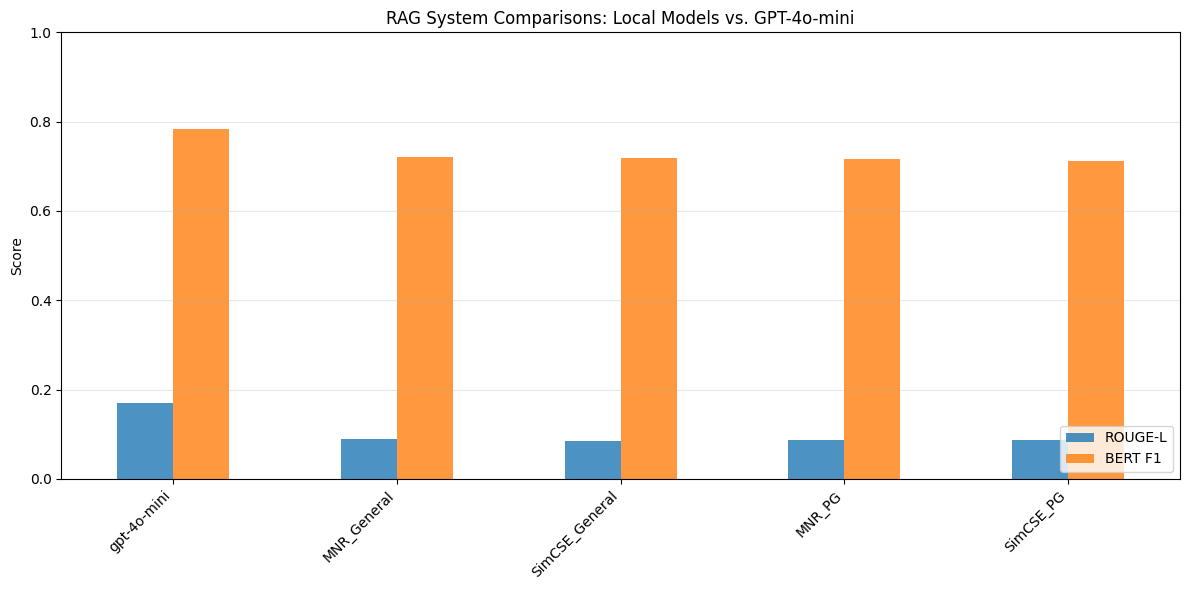


Results saved to 'rag_comps.png'


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
from tqdm import tqdm
import evaluate
from google.colab import userdata

# config
# get the secret key from colab
api_key = userdata.get('open_ai_key')
os.environ["OPENAI_API_KEY"] = api_key #not providing here like the groq, since I'm assuming this is already queued up to grade other notebooks and it isn't as specific as the groq one that you might not have

# Set the model
OPENAI_MODEL = "gpt-4o-mini"
BENCHMARK_FILE = "benchmark_questions.json"

# all models from the prior cell to compare and the benchmark data
local_models = {
    "MNR_General": "rag_results_mnr_general.csv",
    "MNR_PG": "rag_results_mnr_pg.csv",
    "SimCSE_General": "rag_results_simcse_general.csv",
    "SimCSE_PG": "rag_results_simcse_pg.csv"
}

# Initialize Evaluation Metrics
print("Loading Metrics")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Load Benchmark Data
with open(BENCHMARK_FILE, 'r') as f:
    benchmark_data = json.load(f)

questions = [item['question'] for item in benchmark_data]
references = [item['answer'] for item in benchmark_data]

# Dictionary to hold all final scores
all_model_scores = {}


# set up

print(f"\nGenerating Answers with {OPENAI_MODEL}")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
gpt_predictions = []

# set up open ai
for q in tqdm(questions):
    try:
        completion = client.chat.completions.create(
            model=OPENAI_MODEL,
            # set up the role for open ai, don't want to zero shot to give it the best chance of better performance, setting the role to mirror the questions we prepared in our question generation for synthetic data
            messages=[
                {"role": "system", "content": "You are a university professor creating an answer key for an exam on Paul Graham's essays. Answer the question concisely based on your knowledge."},
                {"role": "user", "content": q}
            ],
            temperature=0.0,
            max_tokens=200 # should be enough to answer the questions
        )
        gpt_predictions.append(completion.choices[0].message.content.strip())
    except Exception as e:
        print(f"Error: {e}")
        gpt_predictions.append("")

# Compute GPT Metrics
print(f"Scoring {OPENAI_MODEL}...")
gpt_rouge = rouge.compute(predictions=gpt_predictions, references=references)

# using distilbert since it is lighter than normal bert, but much more efficient for computation than a more powerful roberta model
gpt_bert = bertscore.compute(predictions=gpt_predictions, references=references, lang="en", model_type="distilbert-base-uncased")

# set up scoring for the models
all_model_scores[OPENAI_MODEL] = {
    "ROUGE-L": gpt_rouge['rougeL'],
    "BERT F1": np.mean(gpt_bert['f1'])
}

# Model evaluation
print(f"\nLoading & Scoring Local Models")

for model_name, csv_path in local_models.items():
    if os.path.exists(csv_path):
        print(f"Processing {model_name}...")
        try:
            df = pd.read_csv(csv_path)

            # handle potential nulls
            preds = df['generated_answer'].fillna("").tolist()
            refs = df['reference_answer'].fillna("").tolist()

            # Score it
            r_score = rouge.compute(predictions=preds, references=refs)
            b_score = bertscore.compute(predictions=preds, references=refs, lang="en", model_type="distilbert-base-uncased")

            # save results here
            all_model_scores[model_name] = {
                "ROUGE-L": r_score['rougeL'],
                "BERT F1": np.mean(b_score['f1'])
            }

        # set up error handling
        except Exception as e:
            print(f"Failed to process {model_name}: {e}")
            all_model_scores[model_name] = {"ROUGE-L": 0.0, "BERT F1": 0.0}
    else:
        print(f"File not found for {model_name}: {csv_path}")

# compare and visualize
print("\n" + "-"*50)
print("Results")
print("-"*50)

# Add the results to a df
df_results = pd.DataFrame(all_model_scores).T
df_results = df_results.sort_values(by="BERT F1", ascending=False)
print(df_results)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df_results.plot(kind='bar', ax=ax, alpha=0.8, color=['#1f77b4', '#ff7f0e'])

# Make it prettier
ax.set_ylabel('Score')
ax.set_title('RAG System Comparisons: Local Models vs. GPT-4o-mini')
ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')

# Save and display
plt.tight_layout()
plt.savefig("rag_comps.png")
plt.show()

print("\nResults saved to 'rag_comps.png'")

In [ ]:
import os
from openai import OpenAI

# Initialize OpenAI Client
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def compute_gpt_similarity(gpt_model_version="gpt-4o-mini"):
    print(f"\nCalculating semantic score for {gpt_model_version}...")

    predictions = []
    references = []

    # Iterate through the same validation set
    for entry in tqdm(val_set, desc=f"Querying {gpt_model_version}"):
        user_msg = [msg for msg in entry['messages'] if msg['role'] == 'user'][0]['content']
        ground_truth = [msg for msg in entry['messages'] if msg['role'] == 'model'][0]['content']

        # Call OpenAI API
        try:
            response = client.chat.completions.create(
                model=gpt_model_version,
                messages=[
                    {"role": "user", "content": user_msg}
                ],
                temperature=0, # Keep it deterministic for evaluation
                max_tokens=100
            )
            generated_text = response.choices[0].message.content.strip()

        except Exception as e:
            print(f"Error calling API: {e}")
            generated_text = "" # Handle errors gracefully so loop doesn't break

        predictions.append(generated_text)
        references.append(ground_truth.strip())

    # Calculate Similarity
    gen_embeddings = semantic_model.encode(predictions, convert_to_tensor=True)
    ref_embeddings = semantic_model.encode(references, convert_to_tensor=True)

    cosine_scores = util.cos_sim(gen_embeddings, ref_embeddings)
    similarity_scores = torch.diag(cosine_scores)
    avg_similarity = similarity_scores.mean().item()

    return avg_similarity

gpt_score = compute_gpt_similarity("gpt-4o-mini")

print(f"GPT Baseline Score: {gpt_score:.4f}")

# Update your results dictionary if it exists
if 'semantic_results' in locals():
    semantic_results['gpt'] = gpt_score

    print("\n--- Updated Full Comparison ---")
    # Sort dict by score for a nice leaderboard
    for model, score in sorted(semantic_results.items(), key=lambda item: item[1], reverse=True):
        print(f"{model.ljust(15)}: {score:.4f}")


Calculating semantic score for gpt-4o-mini...


Querying gpt-4o-mini: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it]

GPT Baseline Score: 0.6400

--- Updated Full Comparison ---
gpt            : 0.6400
combined       : 0.5969
base           : 0.5840
synthetic      : 0.5619


Loading Metrics...
Preparing 100 validation samples...

Generating Answers with gpt-4o-mini...


GPT-4o-mini: 100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


Scoring gpt-4o-mini...

Loading & Scoring Local Adapters...

Processing Adapter: base...
Loading weights from ./gemma_lora_adapters/base_final
Could not load adapter base: Adapter with name default already exists. Please use a different name.

Processing Adapter: synthetic...
Loading weights from ./gemma_lora_adapters/synthetic_final
Could not load adapter synthetic: Adapter with name default already exists. Please use a different name.

Processing Adapter: combined...
Loading weights from ./gemma_lora_adapters/combined_final
Could not load adapter combined: Adapter with name default already exists. Please use a different name.

--------------------------------------------------
Results
--------------------------------------------------
              ROUGE-L   BERT F1
gpt-4o-mini  0.196084  0.790887


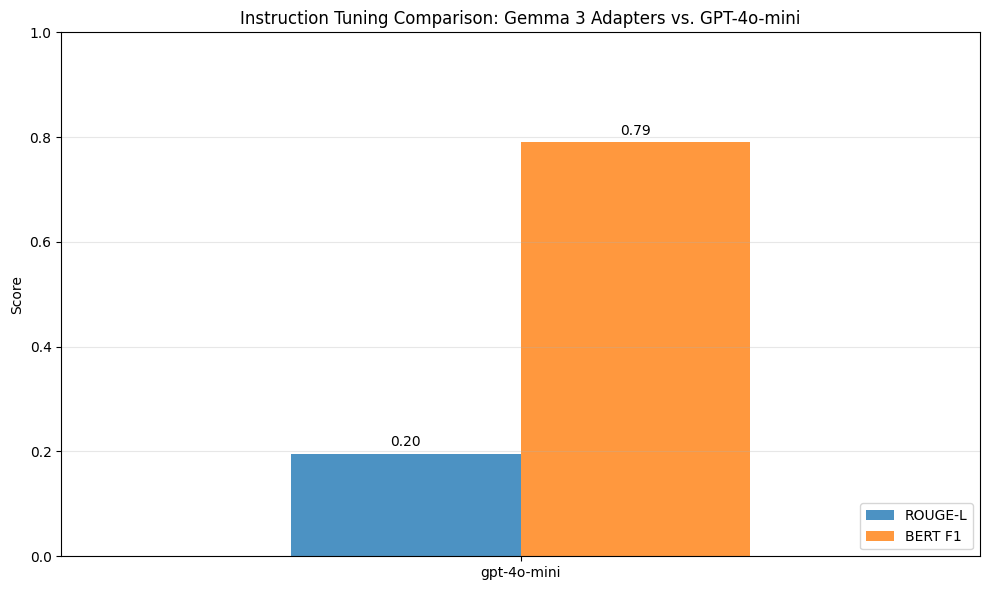


Results saved to 'gemma_adapter_comparison.png'


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from openai import OpenAI
from tqdm import tqdm
import evaluate
from google.colab import userdata

# config
try:
    api_key = userdata.get('open_ai_key')
    os.environ["OPENAI_API_KEY"] = api_key
except:
    print("Warning: Could not load 'open_ai_key' from userdata. Ensure env var is set.")

OPENAI_MODEL = "gpt-4o-mini"
ADAPTER_DIR = "./gemma_lora_adapters"

# compare my Gemma 3 Adapter models to the frontier model
adapters_to_test = ["base", "synthetic", "combined"]

# Initialize Evaluation Metrics
print("Loading Metrics...")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# --- Data Preparation ---
print(f"Preparing {len(val_set)} validation samples...")
questions = []
references = []

for entry in val_set:
    # Extract User Message and Ground Truth Assistant Message
    u_msg = [msg['content'] for msg in entry['messages'] if msg['role'] == 'user'][0]
    g_msg = [msg['content'] for msg in entry['messages'] if msg['role'] == 'model'][0]
    questions.append(u_msg)
    references.append(g_msg)

# Dictionary to hold all final scores
all_model_scores = {}
all_predictions = {}

# GPT Eval
print(f"\nGenerating Answers with {OPENAI_MODEL}...")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
gpt_preds = []

for q in tqdm(questions, desc="GPT-4o-mini"):
    try:
        completion = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role": "user", "content": q}
            ],
            temperature=0.0,
            max_tokens=150
        )
        gpt_preds.append(completion.choices[0].message.content.strip())
    except Exception as e:
        print(f"Error: {e}")
        gpt_preds.append("")

all_predictions[OPENAI_MODEL] = gpt_preds

# Score GPT - scoring the same as the previous one
print(f"Scoring {OPENAI_MODEL}...")
gpt_rouge = rouge.compute(predictions=gpt_preds, references=references)
gpt_bert = bertscore.compute(predictions=gpt_preds, references=references, lang="en", model_type="distilbert-base-uncased")

all_model_scores[OPENAI_MODEL] = {
    "ROUGE-L": gpt_rouge['rougeL'],
    "BERT F1": np.mean(gpt_bert['f1'])
}

# Evaluate local adapter models
print(f"\nLoading & Scoring Local Adapters...")

for adapter_name in adapters_to_test:
    print(f"\nProcessing Adapter: {adapter_name}...")

    # Load the specific adapter
    try:
        full_adapter_path = f"{ADAPTER_DIR}/{adapter_name}_final"
        print(f"Loading weights from {full_adapter_path}")
        gen_model.load_adapter(full_adapter_path)
    except Exception as e:
        print(f"Could not load adapter {adapter_name}: {e}")
        continue

    local_preds = []

    # Generate Loop
    for q in tqdm(questions, desc=f"Generating {adapter_name}"):
        # Format prompt using the tokenizer's chat template
        prompt = tokenizer.apply_chat_template(
            [{"role": "user", "content": q}],
            tokenize=False,
            add_generation_prompt=True
        )
        inputs = tokenizer(prompt, return_tensors="pt").to(gen_model.device)

        with torch.no_grad():
            outputs = gen_model.generate(**inputs, max_new_tokens=150, do_sample=False)

        # Decode and strip prompt
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "assistant\n" in response:
            response = response.split("assistant\n")[-1]

        local_preds.append(response.strip())

    all_predictions[adapter_name] = local_preds

    # Score Adapter
    r_score = rouge.compute(predictions=local_preds, references=references)
    b_score = bertscore.compute(predictions=local_preds, references=references, lang="en", model_type="distilbert-base-uncased")

    all_model_scores[adapter_name] = {
        "ROUGE-L": r_score['rougeL'],
        "BERT F1": np.mean(b_score['f1'])
    }

# Viz and rport
print("Results")

# Create DataFrame
df_results = pd.DataFrame(all_model_scores).T
df_results = df_results.sort_values(by="BERT F1", ascending=False)
print(df_results)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_results.plot(kind='bar', ax=ax, alpha=0.8, color=['#1f77b4', '#ff7f0e'])

# Styling
ax.set_ylabel('Score')
ax.set_title('Instruction Tuning Comparison: Gemma 3 Adapters vs. GPT-4o-mini')
ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.savefig("gemma_adapter_comparison.png")
plt.show()

print("\nResults saved to 'gemma_adapter_comparison.png'")

Re-preparing 100 validation samples...
Loading Metrics...
Found existing GPT scores in memory.

Loading & Scoring Local Adapters...

Processing Adapter: base...


Generating base: 100%|██████████| 100/100 [19:12<00:00, 11.53s/it]



Processing Adapter: synthetic...


Generating synthetic: 100%|██████████| 100/100 [19:01<00:00, 11.42s/it]



Processing Adapter: combined...


Generating combined: 100%|██████████| 100/100 [19:03<00:00, 11.43s/it]



--------------------------------------------------
Final Comparison
--------------------------------------------------
              ROUGE-L   BERT F1
gpt-4o-mini  0.196084  0.790887
base         0.147411  0.747972
combined     0.159088  0.740327
synthetic    0.151321  0.728614


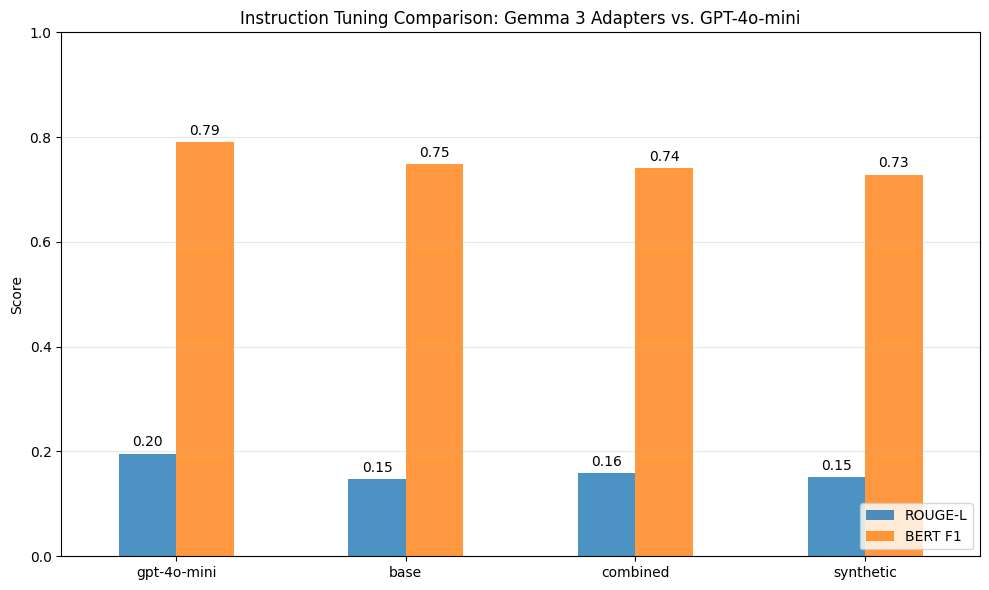

In [ ]:
# Since the gemma adapters didn't call out of memory in the prior cell, we are rerunning to troubleshoot without incurring the openAI API call cost again.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import evaluate

# --- 1. Setup Data & Metrics
print(f"Re-preparing {len(val_set)} validation samples...")
questions = []
references = []

for entry in val_set:
    u_msg = [msg['content'] for msg in entry['messages'] if msg['role'] == 'user'][0]
    g_msg = [msg['content'] for msg in entry['messages'] if msg['role'] == 'model'][0]
    questions.append(u_msg)
    references.append(g_msg)

print("Loading Metrics...")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Get GPT model from memory if available
if 'all_model_scores' not in locals():
    all_model_scores = {}

# If GPT is missing from the dictionary, add the scores you just got manually - hard coding is bad, but this can be updated as needed and a second call could be made to openai if this works
if "gpt-4o-mini" not in all_model_scores:
    print("Restoring GPT baseline from previous run logs...")
    all_model_scores["gpt-4o-mini"] = {
        "ROUGE-L": 0.1961,
        "BERT F1": 0.7909
    }
else:
    print("Found existing GPT scores in memory.")

# Local adapter models
ADAPTER_DIR = "./gemma_lora_adapters"
adapters_to_test = ["base", "synthetic", "combined"]

try:
    gen_model.delete_adapter("default")
except:
    pass

print(f"\nLoading & Scoring Local Adapters...")

for adapter_name in adapters_to_test:
    print(f"\nProcessing Adapter: {adapter_name}...")

    full_adapter_path = f"{ADAPTER_DIR}/{adapter_name}_final"

    try:
        # Load with explicit name
        gen_model.load_adapter(full_adapter_path, adapter_name=adapter_name)
        gen_model.set_adapter(adapter_name)
    except Exception as e:
        print(f"Could not load adapter {adapter_name}: {e}")
        continue

    local_preds = []

    # Generate
    for q in tqdm(questions, desc=f"Generating {adapter_name}"):
        prompt = tokenizer.apply_chat_template(
            [{"role": "user", "content": q}],
            tokenize=False,
            add_generation_prompt=True
        )
        inputs = tokenizer(prompt, return_tensors="pt").to(gen_model.device)

        with torch.no_grad():
            outputs = gen_model.generate(**inputs, max_new_tokens=150, do_sample=False)

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "assistant\n" in response:
            response = response.split("assistant\n")[-1]

        local_preds.append(response.strip())

    # Score
    r_score = rouge.compute(predictions=local_preds, references=references)
    b_score = bertscore.compute(predictions=local_preds, references=references, lang="en", model_type="distilbert-base-uncased")

    all_model_scores[adapter_name] = {
        "ROUGE-L": r_score['rougeL'],
        "BERT F1": np.mean(b_score['f1'])
    }

    # Cleanup immediately to prevent memory issues or naming conflicts
    gen_model.delete_adapter(adapter_name)

# Plot
print("\n" + "-"*50)
print("Final Comparison")
print("-"*50)

df_results = pd.DataFrame(all_model_scores).T
df_results = df_results.sort_values(by="BERT F1", ascending=False)
print(df_results)

fig, ax = plt.subplots(figsize=(10, 6))
df_results.plot(kind='bar', ax=ax, alpha=0.8, color=['#1f77b4', '#ff7f0e'])

ax.set_ylabel('Score')
ax.set_title('Instruction Tuning Comparison: Gemma 3 Adapters vs. GPT-4o-mini')
ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.legend(loc='lower right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()